In [19]:
import pertpy as pt
import scanpy as sc
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
from scipy import stats

from statsmodels.sandbox.stats.multicomp import multipletests


In [20]:
%load_ext autoreload
%autoreload 2

import importlib
importlib.reload(pt)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Installed version 0.4.0 of pertpy is newer than the latest release 0.3.0! You are running a nightly version and 
features may break!

<module 'pertpy' from '/Users/tessa/miniforge3/envs/pertpy5/lib/python3.9/site-packages/pertpy/__init__.py'>

In [21]:
adata = sc.read_h5ad("zhang_with_PCs.h5ad")

In [22]:
# tumor samples only
adata = adata[adata.obs['Origin']=="t" ,:].copy()

In [23]:
# pre-treatment samples only 
adata = adata[adata.obs['Sample'].str.contains('Pre'),:].copy()

In [24]:
# isecs = adata.obs.groupby(["Cluster", "Sample"]).size()
isecs = pd.crosstab(adata.obs['Cluster'], adata.obs['Sample'])

(array([ 5.,  8.,  6.,  1.,  8.,  3., 10.,  4.,  7.,  5.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

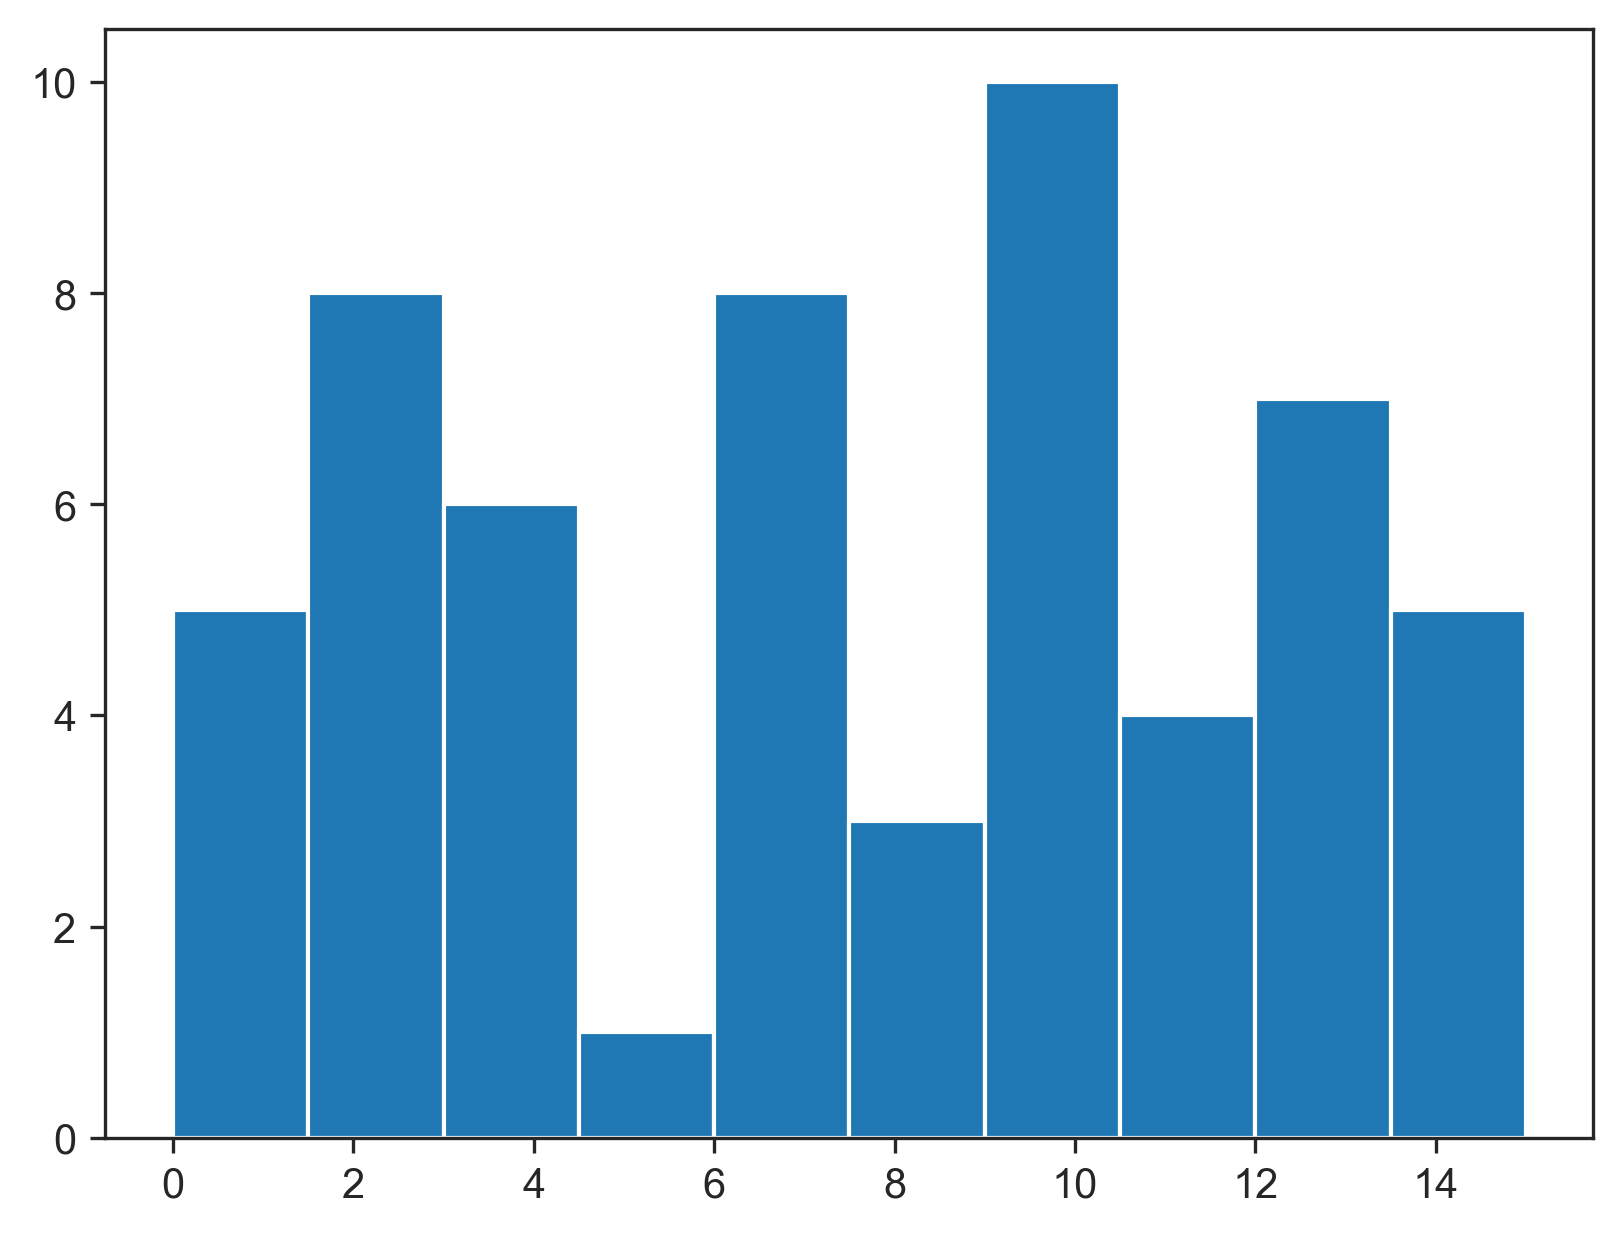

In [25]:
plt.hist((isecs >3).sum(axis=1))

In [26]:
isecs[(isecs > 3).sum(axis=1) == np.shape(isecs)[1]]

Sample      Pre_P002_t  Pre_P004_t  Pre_P005_t  Pre_P007_t  Pre_P010_t  \
Cluster                                                                  
t_pB-IGHG1         679           8          12          12           4   

Sample      Pre_P012_t  Pre_P013_t  Pre_P016_t  Pre_P017_t  Pre_P018_t  \
Cluster                                                                  
t_pB-IGHG1         301           4         136          14         238   

Sample      Pre_P019_t  Pre_P020_t  Pre_P022_t  Pre_P023_t  Pre_P025_t  
Cluster                                                                 
t_pB-IGHG1        1753         911        1083         206         283

In [27]:
isecs[(isecs > 3).sum(axis=1) == np.shape(isecs)[1]-1]

# drop sample Pre_P010_t 

Sample            Pre_P002_t  Pre_P004_t  Pre_P005_t  Pre_P007_t  Pre_P010_t  \
Cluster                                                                        
t_CD4_Tcm-LMNA             4         392         569         249           0   
t_CD4_Treg-FOXP3          13         338         110          62           0   
t_CD8_Tem-GZMK             8         957         368          72           0   
t_Tn-LEF1                 11          98         110        3494           0   

Sample            Pre_P012_t  Pre_P013_t  Pre_P016_t  Pre_P017_t  Pre_P018_t  \
Cluster                                                                        
t_CD4_Tcm-LMNA           288           6         311          20         134   
t_CD4_Treg-FOXP3         464          24         419          17         518   
t_CD8_Tem-GZMK           417          17         176          21         154   
t_Tn-LEF1               1269          22          50         609         167   

Sample            Pre_P019_t  Pre_P020_t  Pre_P022_t  Pre_P023_t  Pre_P025_t  
Cluster                                                                       
t_CD4_Tcm-LMNA           555          77         593         444          87  
t_CD4_Treg-FOXP3         769         743         398         122         130  
t_CD8_Tem-GZMK          2354         202         709         891         292  
t_Tn-LEF1               4010         175        1501         388         271

In [28]:
isecs[(isecs > 3).sum(axis=1) == np.shape(isecs)[1]-2]
# drop Pre_P013_t, Pre_P017_t, Pre_P002_2

Sample            Pre_P002_t  Pre_P004_t  Pre_P005_t  Pre_P007_t  Pre_P010_t  \
Cluster                                                                        
t_Bmem-CD27              377          11          12         105           0   
t_CD8_MAIT-KLRB1           0          51        1244          45           0   
t_CD8_Trm-ZNF683           3          76         180          71           0   
t_mono-FCN1                4          60          11          12           0   

Sample            Pre_P012_t  Pre_P013_t  Pre_P016_t  Pre_P017_t  Pre_P018_t  \
Cluster                                                                        
t_Bmem-CD27             1950           0          11         166          22   
t_CD8_MAIT-KLRB1          40           7          84          24          19   
t_CD8_Trm-ZNF683         143           4         407           4         226   
t_mono-FCN1               14          23          44           1          31   

Sample            Pre_P019_t  Pre_P020_t  Pre_P022_t  Pre_P023_t  Pre_P025_t  
Cluster                                                                       
t_Bmem-CD27             4210         132         309         121         400  
t_CD8_MAIT-KLRB1          67          14          38          20          11  
t_CD8_Trm-ZNF683         422         121         449         219         150  
t_mono-FCN1               43          15          51          33          16

In [29]:
celltypes = isecs[(isecs > 3).sum(axis=1) >= np.shape(isecs)[1]-2].index.values.to_list()

In [30]:
# subset to cell types with sufficient expression
adata = adata[adata.obs['Cluster'].isin(celltypes),:].copy()

In [31]:
adata

AnnData object with n_obs × n_vars = 44636 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [32]:
isecs = pd.crosstab(adata.obs['Cluster'], adata.obs['Sample'])

In [33]:
keep_pts = isecs.loc[:,(isecs > 3).sum(axis=0) == isecs.shape[0]].columns.values.to_list()

In [34]:
adata = adata[adata.obs['Sample'].isin(keep_pts),:].copy()

In [35]:
pd.crosstab(adata.obs['Cluster'], adata.obs['Sample']).min(axis=1)

Cluster
t_Bmem-CD27         11
t_CD4_Tcm-LMNA      77
t_CD4_Treg-FOXP3    62
t_CD8_MAIT-KLRB1    11
t_CD8_Tem-GZMK      72
t_CD8_Trm-ZNF683    71
t_Tn-LEF1           50
t_mono-FCN1         11
t_pB-IGHG1           8
dtype: int64

In [36]:
pd.crosstab(adata.obs['Cluster'], adata.obs['Sample']).min(axis=0)

Sample
Pre_P004_t     8
Pre_P005_t    11
Pre_P007_t    12
Pre_P012_t    14
Pre_P016_t    11
Pre_P018_t    19
Pre_P019_t    43
Pre_P020_t    14
Pre_P022_t    38
Pre_P023_t    20
Pre_P025_t    11
dtype: int64

In [37]:
# cell counts look passable (though definitely low for some -- could consider dropping more things)

In [38]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [39]:
adata.obs.columns

Index(['Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group',
       'Treatment', 'Number of counts', 'Number of genes', 'Major celltype',
       'Cluster'],
      dtype='object')

In [ ]:
sc.pl.umap(
    adata,
    color=[
        "Sample"
    ],
)

# definitely sample splitting -- unclear if batch effect vs interpatient variation

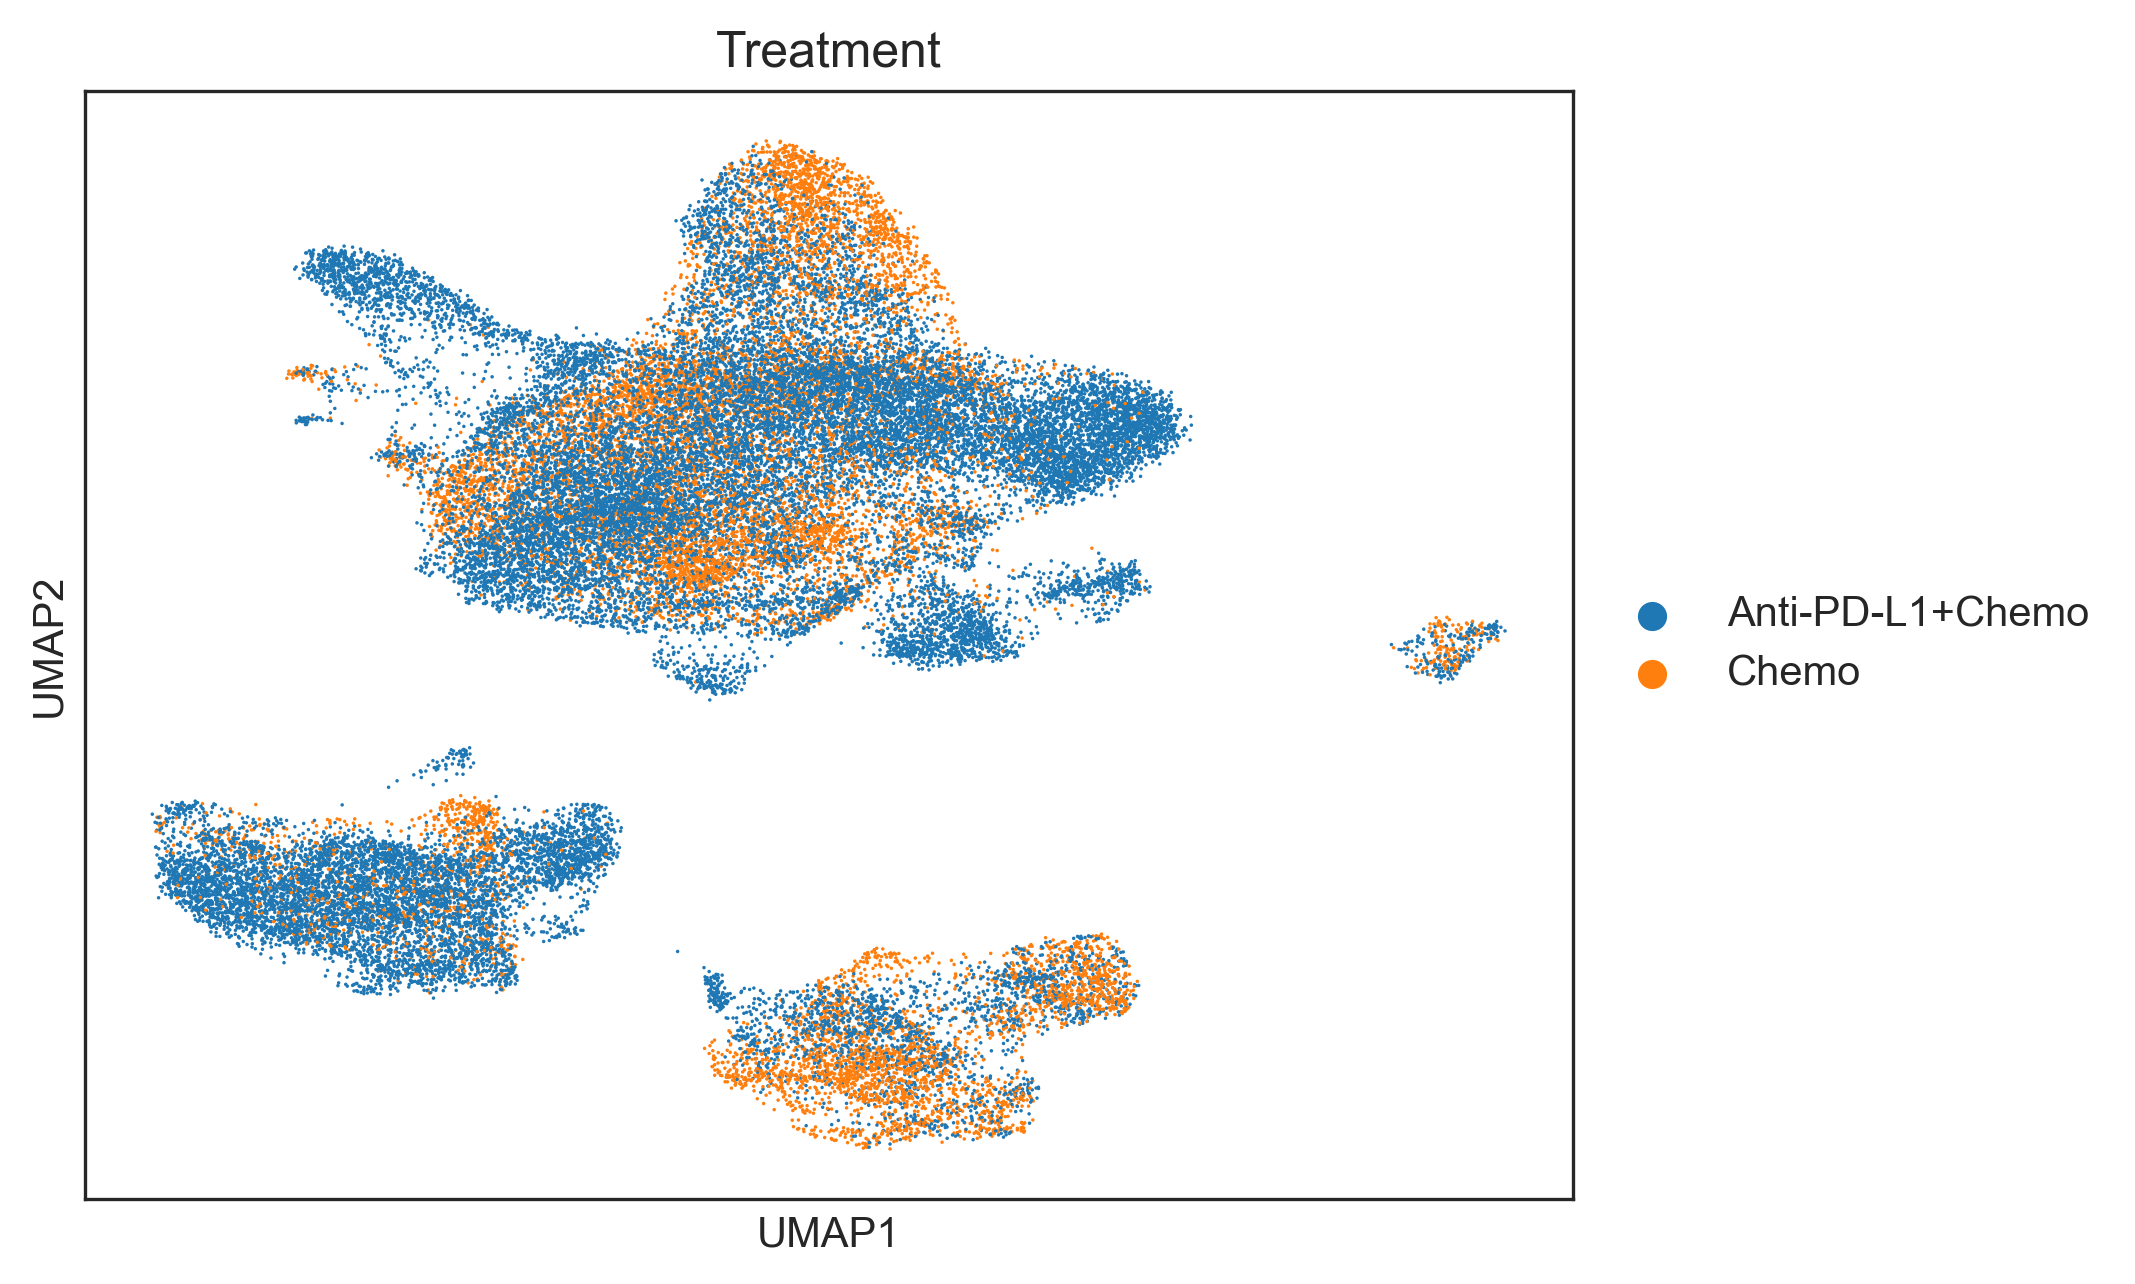

In [23]:
sc.pl.umap(
    adata,
    color=[
        "Treatment"
    ],
)

In [41]:
sc.pl.umap(
    adata,
    color=[
        "Cluster"
    ],
)

In [ ]:
sc.pl.umap(
    adata,
    color=[
        "Efficacy"
    ],
)

In [47]:
dl = pt.tl.Dialogue(sample_id = "Sample",
                   celltype_key = "Cluster",
                   n_counts_key = "Number of counts",
                   n_mpcs = 3)

In [48]:
adata

AnnData object with n_obs × n_vars = 42550 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'Sample_colors', 'Cluster_colors', 'Efficacy_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [53]:
adata, mcps, ws, ct_subs = dl.calculate_multifactor_PMD(
    adata,
    normalize=True,
    solver="bs"
)

#adata, mcps, ws, ct_subs = dl.calculate_multifactor_PMD(
#    adata,
#    groupby='Sample',
#    celltype_key='Cluster',
#    mimic_dialogue=True,
#    n_components=10
#)

ValueError: could not convert string to float: '1,068 '

In [30]:
# need to implement automated chi-squared testing of efficacy w MCPs
# 
# also something for multiple testing correction

# and then need plotting utilities 
#  I'd like to get the pairs plots but need to decide which cells count as in MCP 

# also -- MCP membership -- how does that work here? 
# want to choose ones with decent correlations

In [51]:
check_array(adata.X)

NameError: name 'check_array' is not defined

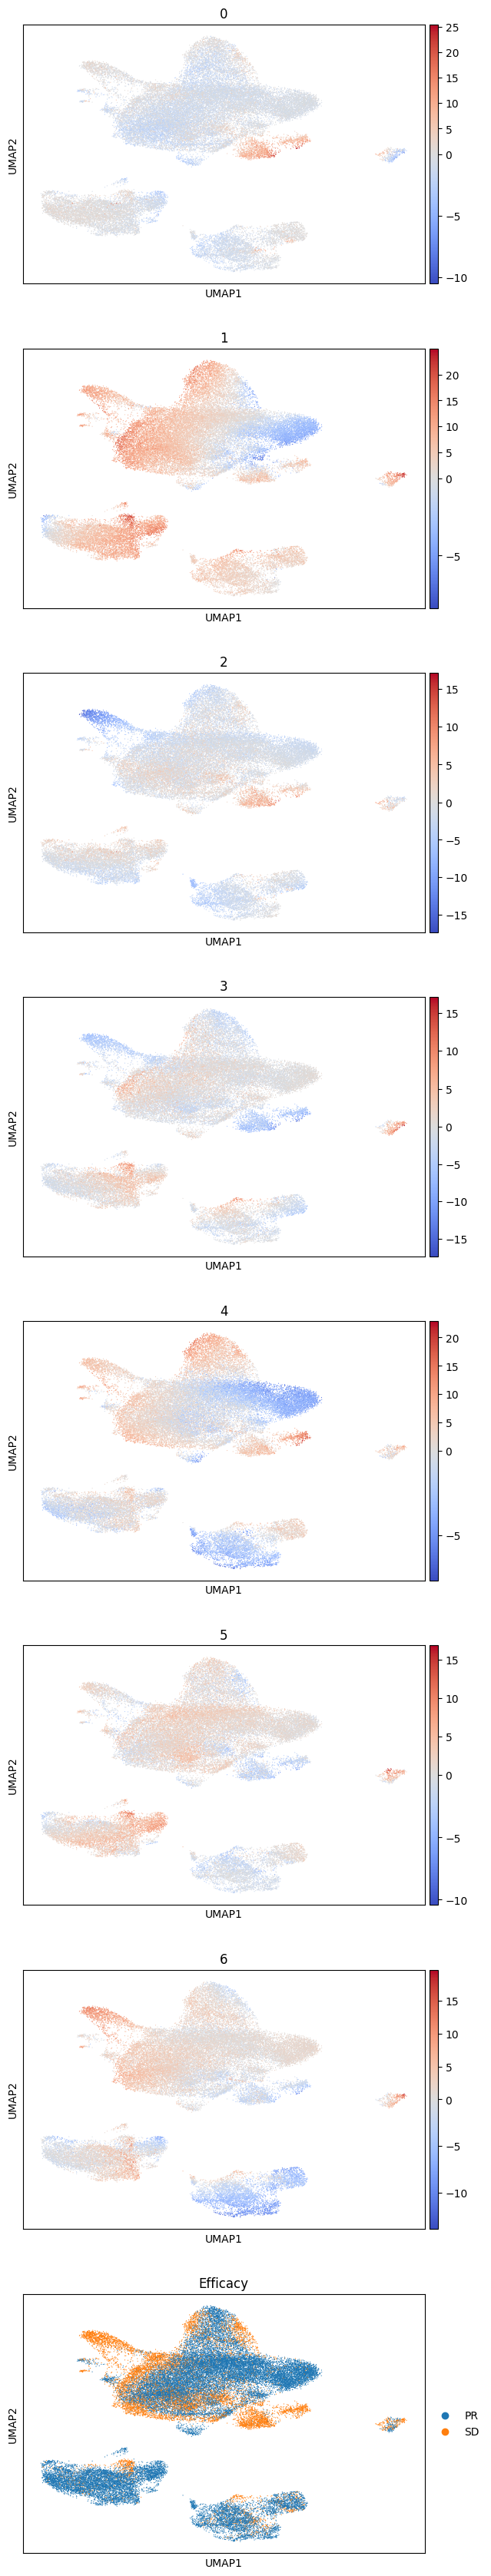

In [35]:
sc.pl.umap(adata, color=[0, 1, 2,3,4,5,6,"Efficacy"], ncols=1, cmap='coolwarm', vcenter=0)


In [36]:
adata

AnnData object with n_obs × n_vars = 42550 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
    uns: 'Efficacy_colors'
    obsm: 'X_pca', 'X_umap'

In [37]:
adata.obs.columns

Index([          'Sample',          'Patient',           'Origin',
                 'Tissue',         'Efficacy',            'Group',
              'Treatment', 'Number of counts',  'Number of genes',
         'Major celltype',          'Cluster',                  0,
                        1,                  2,                  3,
                        4,                  5,                  6,
                        7,                  8,                  9],
      dtype='object')

In [40]:
for 

AnnData object with n_obs × n_vars = 42550 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
    uns: 'Efficacy_colors'
    obsm: 'X_pca', 'X_umap'

['t_Bmem-CD27',
 't_CD4_Tcm-LMNA',
 't_CD4_Treg-FOXP3',
 't_CD8_MAIT-KLRB1',
 't_CD8_Tem-GZMK',
 't_CD8_Trm-ZNF683',
 't_Tn-LEF1',
 't_mono-FCN1',
 't_pB-IGHG1']

In [66]:
adata.obs.columns = adata.obs.columns.astype(str)

In [161]:
pvals = pd.DataFrame(1, adata.obs['Cluster'].unique().tolist(), [str(n) for n in range(0,10)])
tstats = pd.DataFrame(1, adata.obs['Cluster'].unique().tolist(), [str(n) for n in range(0,10)])
response = adata.obs.groupby('Sample')['Efficacy'].agg(pd.Series.mode)
res = dict()
for celltype in adata.obs['Cluster'].unique().tolist():
    df = adata.obs[adata.obs['Cluster']==celltype]

    for mcpnum in [str(n) for n in range(0,10)]:
        mns = df.groupby('Sample')[mcpnum].mean()
        mns = pd.concat([mns,response],axis=1)
        res = stats.ttest_ind(mns[mns['Efficacy']=='PR'][mcpnum],mns[mns['Efficacy']=='SD'][mcpnum])
        pvals.loc[celltype, mcpnum]=res[1]
        tstats.loc[celltype, mcpnum]=res[0]

In [133]:
res = stats.ttest_ind(mns[mns['Efficacy']=='PR']['1'],mns[mns['Efficacy']=='SD']['1'])

In [162]:
pvals # haven't multiple test corrected, but 4 and 8 look interesting

0         1         2         3         4         5  \
t_Bmem-CD27       0.104291  0.690228  0.681062  0.753979  0.008144  0.809332   
t_CD4_Tcm-LMNA    0.136635  0.355506  0.510937  0.479628  0.005573  0.631223   
t_CD4_Treg-FOXP3  0.095285  0.592652  0.846933  0.558570  0.023602  0.933198   
t_CD8_MAIT-KLRB1  0.109980  0.387031  0.973376  0.574268  0.009765  0.632477   
t_CD8_Tem-GZMK    0.127577  0.447146  0.540392  0.625532  0.020153  0.875241   
t_CD8_Trm-ZNF683  0.123480  0.609092  0.367487  0.505177  0.016777  0.733532   
t_Tn-LEF1         0.125643  0.516695  0.412555  0.641894  0.006156  0.537395   
t_mono-FCN1       0.134306  0.274081  0.765286  0.733152  0.064217  0.714835   
t_pB-IGHG1        0.088807  0.293315  0.990742  0.814966  0.008721  0.195427   

                         6         7         8         9  
t_Bmem-CD27       0.496655  0.223676  0.007458  0.660198  
t_CD4_Tcm-LMNA    0.562465  0.100366  0.010545  0.966575  
t_CD4_Treg-FOXP3  0.510805  0.207726  0.391373  0.641898  
t_CD8_MAIT-KLRB1  0.753900  0.128154  0.177591  0.591659  
t_CD8_Tem-GZMK    0.930776  0.171556  0.057394  0.767685  
t_CD8_Trm-ZNF683  0.476112  0.160120  0.014530  0.610766  
t_Tn-LEF1         0.495217  0.216277  0.030612  0.336263  
t_mono-FCN1       0.393231  0.123302  0.196765  0.820779  
t_pB-IGHG1        0.369539  0.138293  0.044292  0.952817

In [176]:
p_adjusted = multipletests(pvals.transpose()['t_CD4_Treg-FOXP3'], method='bonferroni')

In [178]:
# I'm not sure what makes sense a multiple testing correction here
# treating the MCPs as independent and doing bonferroni on a given cell type indicates no significant correlations

In [179]:
multipletests(pvals.transpose()['t_Bmem-CD27'], method='bonferroni')

(array([False, False, False, False, False, False, False, False, False,
        False]),
 array([1.        , 1.        , 1.        , 1.        , 0.08144188,
        1.        , 1.        , 1.        , 0.07457995, 1.        ]),
 0.005116196891823743,
 0.005)

In [181]:
multipletests(pvals.transpose()['t_Tn-LEF1'], method='bonferroni')

(array([False, False, False, False, False, False, False, False, False,
        False]),
 array([1.        , 1.        , 1.        , 1.        , 0.06156236,
        1.        , 1.        , 1.        , 0.30611572, 1.        ]),
 0.005116196891823743,
 0.005)

In [185]:
multipletests(pvals['4'], method='bonferroni')

(array([False, False, False, False, False, False, False, False, False]),
 array([0.07329769, 0.05015518, 0.21242086, 0.087883  , 0.18137732,
        0.15099661, 0.05540613, 0.57795322, 0.07848545]),
 0.005683044988048058,
 0.005555555555555556)

In [186]:
multipletests(pvals['8'], method='bonferroni')

(array([False, False, False, False, False, False, False, False, False]),
 array([0.06712195, 0.09490321, 1.        , 1.        , 0.51654228,
        0.1307671 , 0.27550415, 1.        , 0.39863003]),
 0.005683044988048058,
 0.005555555555555556)

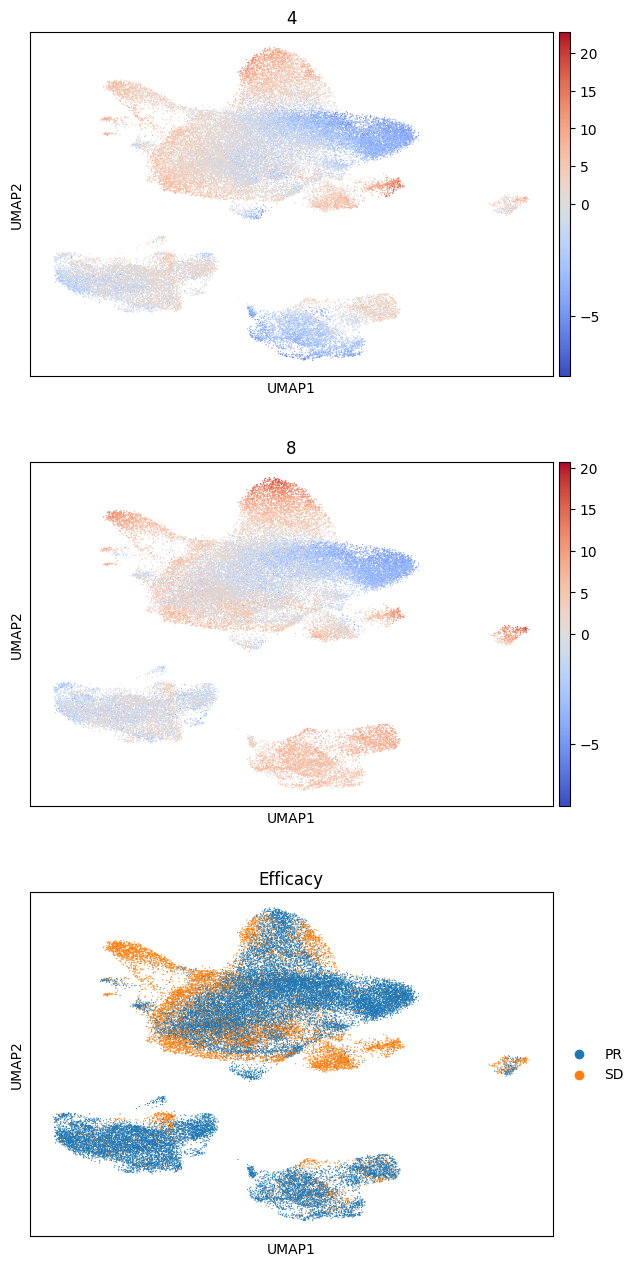

In [187]:
sc.pl.umap(adata, color=['4','8',"Efficacy"], ncols=1, cmap='coolwarm', vcenter=0)


[Text(0, 0, 't_Bmem-CD27'),
 Text(1, 0, 't_CD4_Tcm-LMNA'),
 Text(2, 0, 't_CD4_Treg-FOXP3'),
 Text(3, 0, 't_CD8_MAIT-KLRB1'),
 Text(4, 0, 't_CD8_Tem-GZMK'),
 Text(5, 0, 't_CD8_Trm-ZNF683'),
 Text(6, 0, 't_Tn-LEF1'),
 Text(7, 0, 't_mono-FCN1'),
 Text(8, 0, 't_pB-IGHG1')]

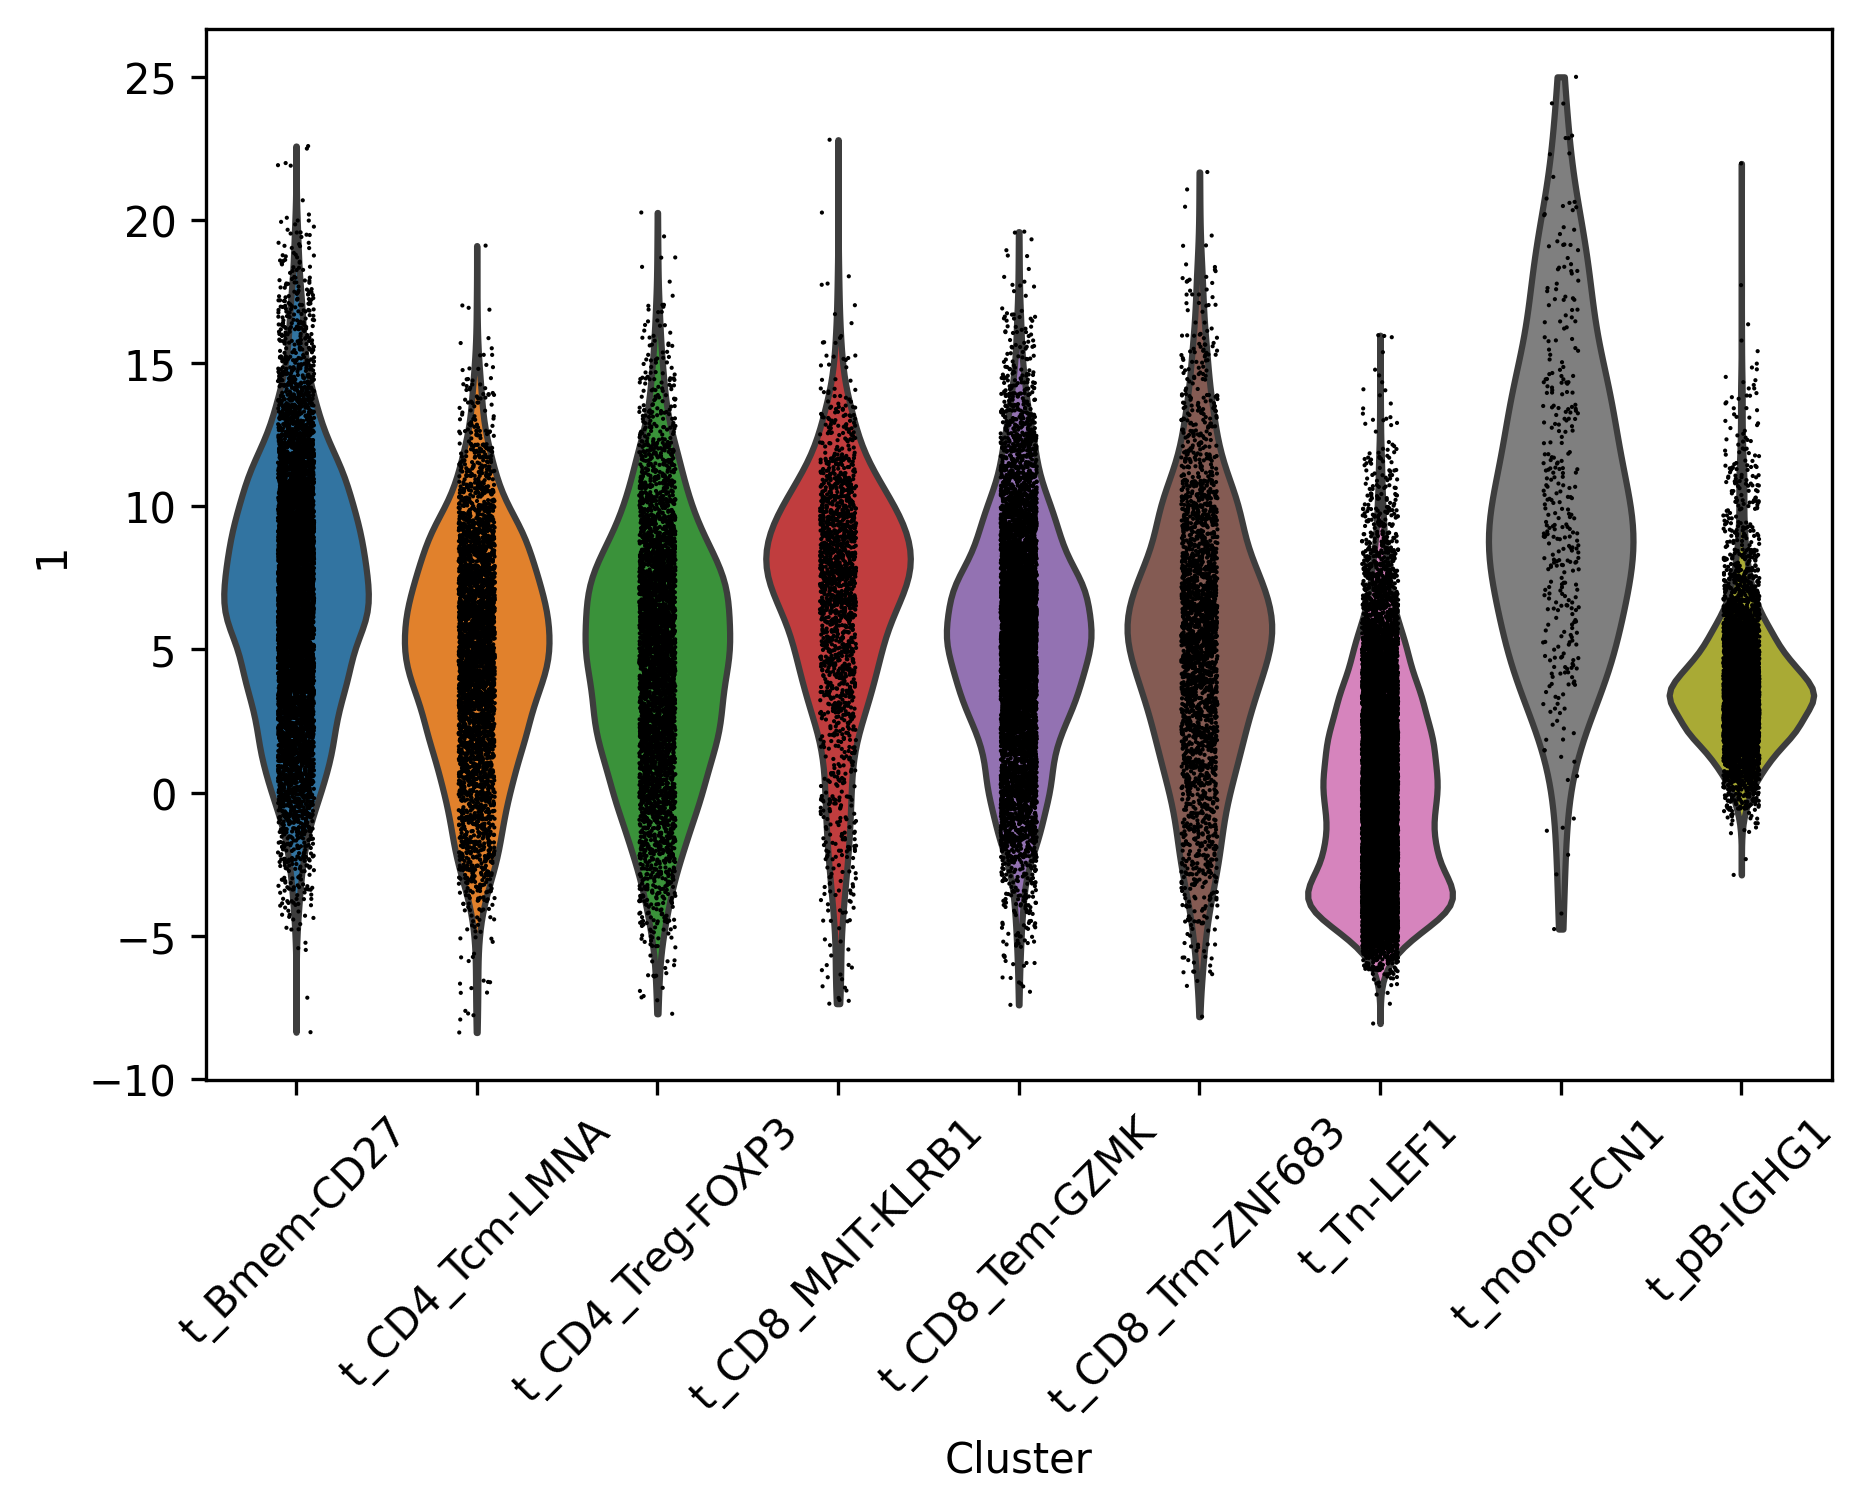

In [207]:
p = sc.pl.violin(adata, '1', groupby= "Cluster", show=False)
p.set_xticklabels(p.get_xticklabels(), rotation=45)



[Text(0, 0, 't_Bmem-CD27'),
 Text(1, 0, 't_CD4_Tcm-LMNA'),
 Text(2, 0, 't_CD4_Treg-FOXP3'),
 Text(3, 0, 't_CD8_MAIT-KLRB1'),
 Text(4, 0, 't_CD8_Tem-GZMK'),
 Text(5, 0, 't_CD8_Trm-ZNF683'),
 Text(6, 0, 't_Tn-LEF1'),
 Text(7, 0, 't_mono-FCN1'),
 Text(8, 0, 't_pB-IGHG1')]

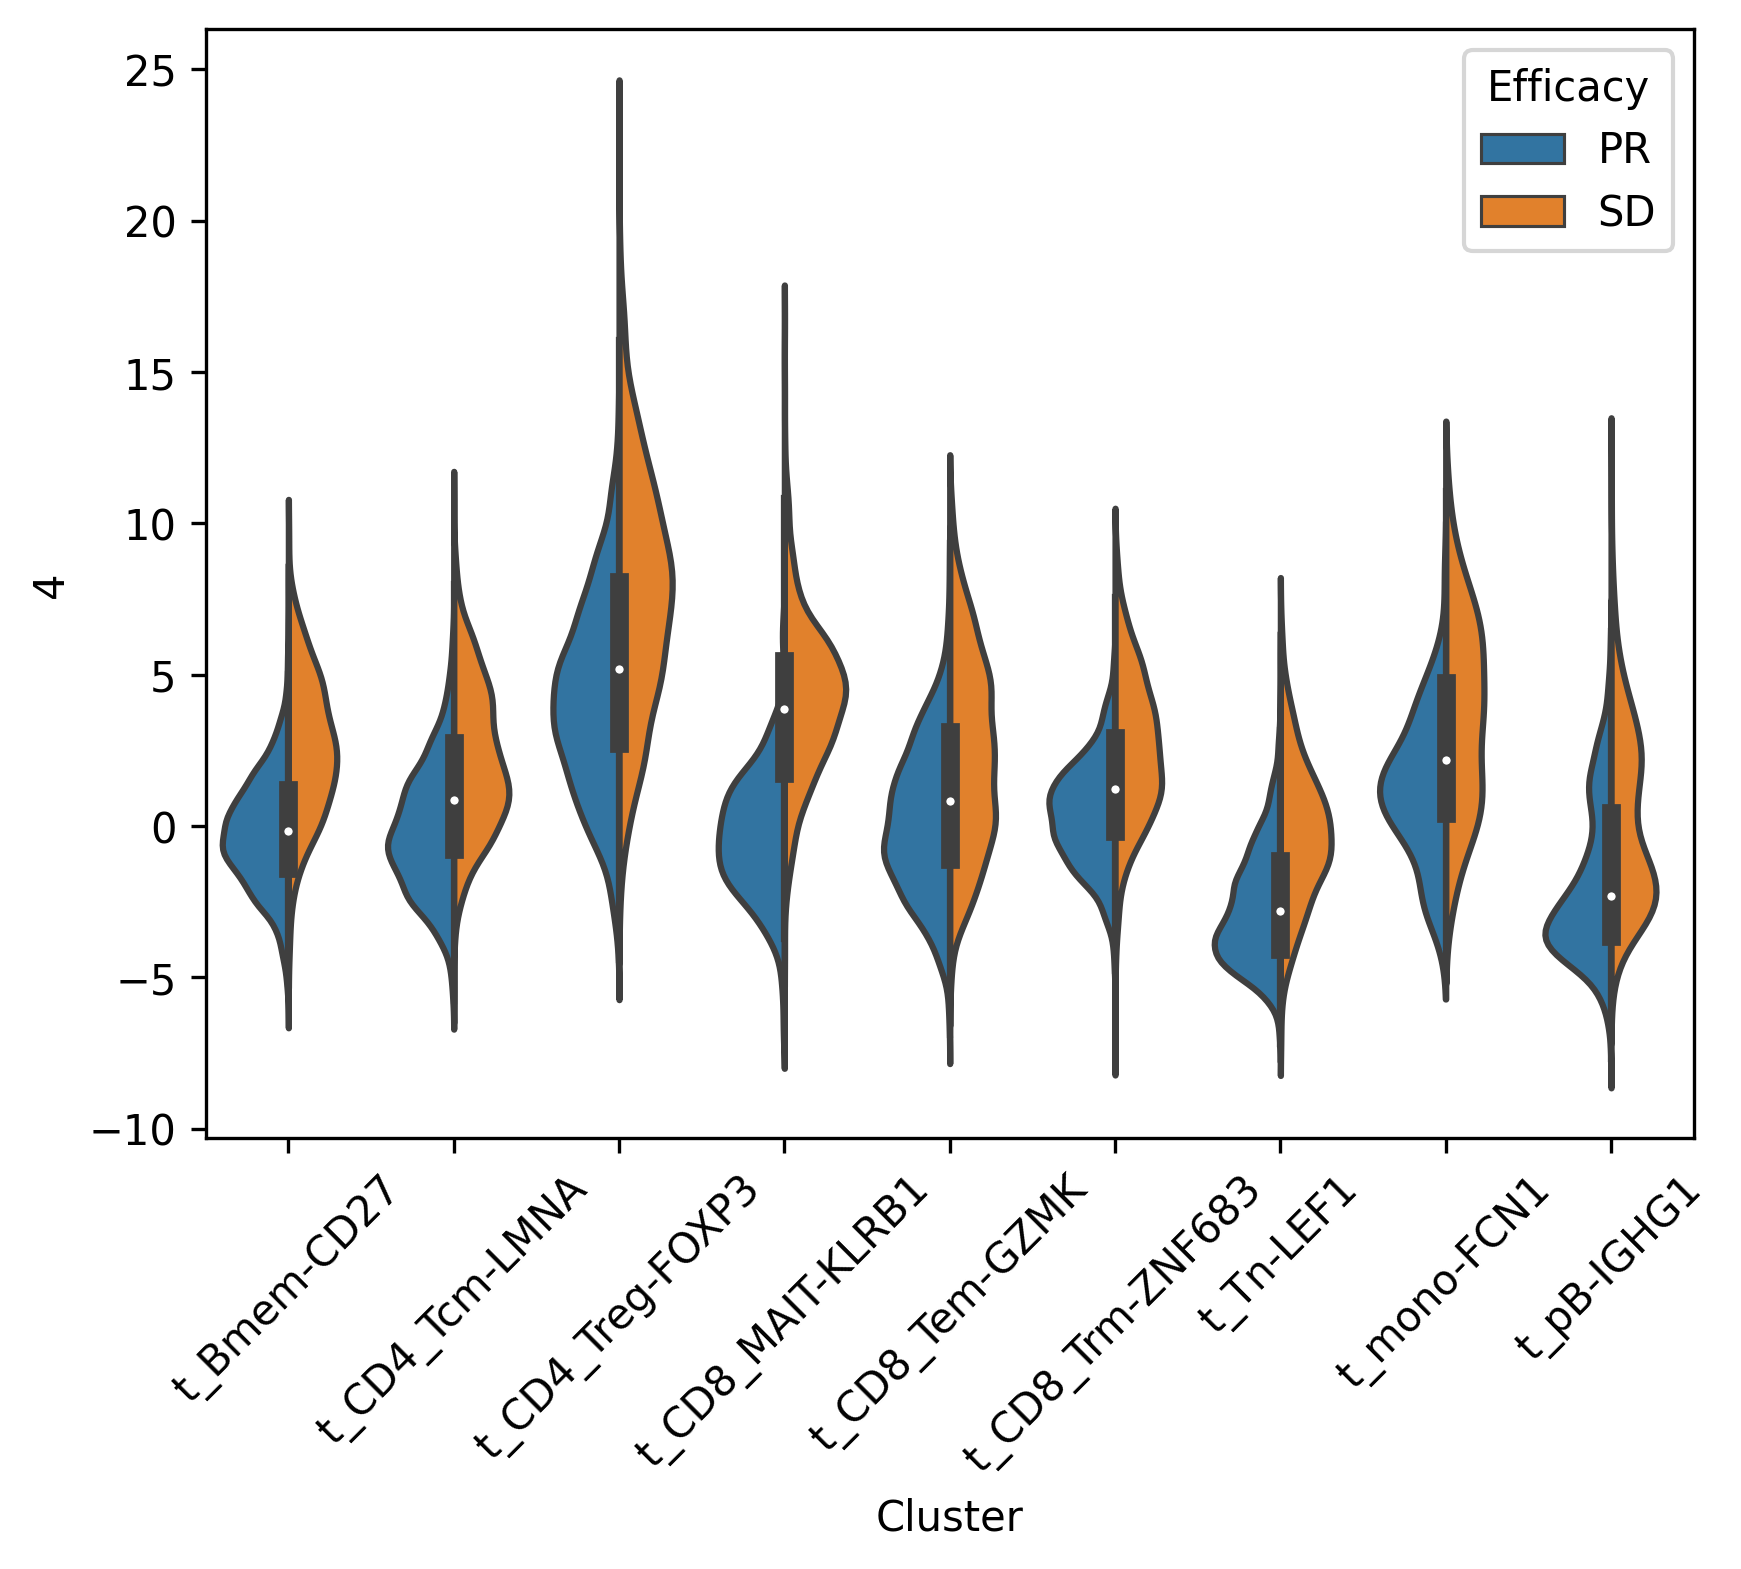

In [252]:
df = sc.get.obs_df(adata, ['Cluster','4', 'Efficacy'])
#df = df.set_index('Efficacy').stack().reset_index()
#df.columns = []
#df.columns = ['Efficacy', 'MCP', 'value']
#import seaborn as sns
#sns.violinplot(data=df, x='gene', y='value', hue="louvain",
#                split=True, inner="quart", linewidth=1)    

p2 = sns.violinplot(data=df, x="Cluster",y="4",hue="Efficacy", split=True)
p2.set_xticklabels(p2.get_xticklabels(), rotation=45)


[Text(0, 0, 't_Bmem-CD27'),
 Text(1, 0, 't_CD4_Tcm-LMNA'),
 Text(2, 0, 't_CD4_Treg-FOXP3'),
 Text(3, 0, 't_CD8_MAIT-KLRB1'),
 Text(4, 0, 't_CD8_Tem-GZMK'),
 Text(5, 0, 't_CD8_Trm-ZNF683'),
 Text(6, 0, 't_Tn-LEF1'),
 Text(7, 0, 't_mono-FCN1'),
 Text(8, 0, 't_pB-IGHG1')]

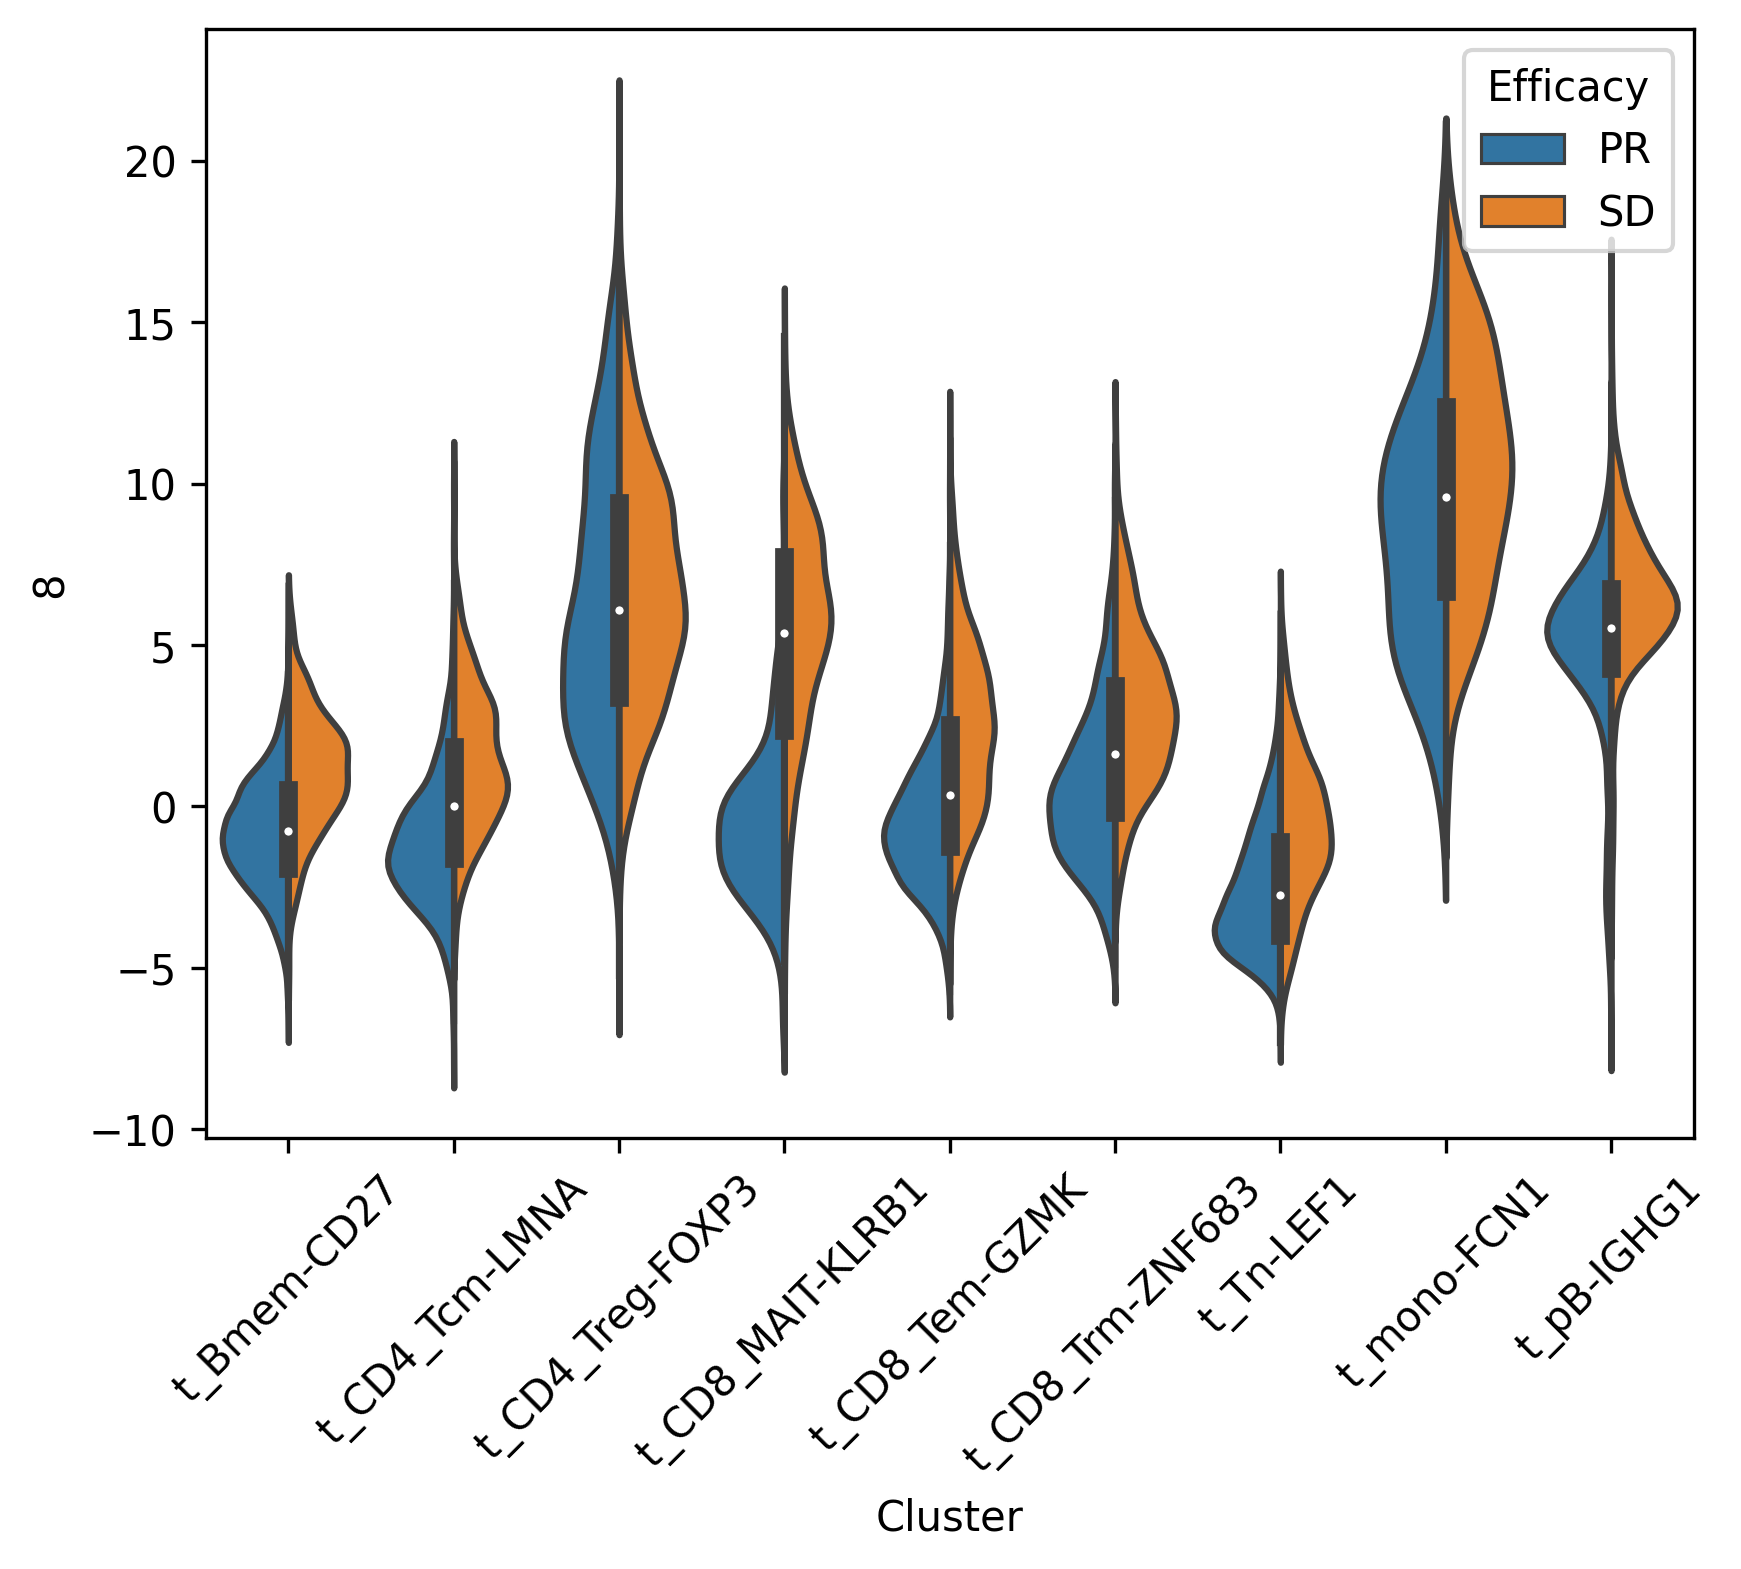

In [253]:
df = sc.get.obs_df(adata, ['Cluster','8', 'Efficacy'])
#df = df.set_index('Efficacy').stack().reset_index()
#df.columns = []
#df.columns = ['Efficacy', 'MCP', 'value']
#import seaborn as sns
#sns.violinplot(data=df, x='gene', y='value', hue="louvain",
#                split=True, inner="quart", linewidth=1)    

p2 = sns.violinplot(data=df, x="Cluster",y="8",hue="Efficacy", split=True)
p2.set_xticklabels(p2.get_xticklabels(), rotation=45)

In [242]:
sc.get.obs_df(adata, ['Cluster','4', 'Efficacy'])

Cluster         4 Efficacy
Cell barcode                                               
AAATGCCTCATCTGCC.Pre_P007_t  t_Bmem-CD27 -2.364669       PR
AATCCAGAGCGTTCCG.Pre_P007_t  t_Bmem-CD27 -0.284651       PR
ACAGCCGAGCACCGCT.Pre_P007_t  t_Bmem-CD27 -0.978295       PR
ACCGTAAAGCTAACTC.Pre_P007_t  t_Bmem-CD27  1.087998       PR
ACGAGCCTCGTAGGTT.Pre_P007_t  t_Bmem-CD27 -1.083146       PR
...                                  ...       ...      ...
CGGGTCAGTTCCCGAG.Pre_P004_t   t_pB-IGHG1  8.585988       SD
GCTTGAACAGGCTGAA.Pre_P004_t   t_pB-IGHG1  1.445790       SD
GTCGGGTGTCCGAATT.Pre_P004_t   t_pB-IGHG1  5.622560       SD
TCATTTGTCAATACCG.Pre_P004_t   t_pB-IGHG1  1.665304       SD
TCTCATATCCAAAGTC.Pre_P004_t   t_pB-IGHG1 -0.539101       SD

[42550 rows x 3 columns]

[Text(0, 0, 't_Bmem-CD27'),
 Text(1, 0, 't_CD4_Tcm-LMNA'),
 Text(2, 0, 't_CD4_Treg-FOXP3'),
 Text(3, 0, 't_CD8_MAIT-KLRB1'),
 Text(4, 0, 't_CD8_Tem-GZMK'),
 Text(5, 0, 't_CD8_Trm-ZNF683'),
 Text(6, 0, 't_Tn-LEF1'),
 Text(7, 0, 't_mono-FCN1'),
 Text(8, 0, 't_pB-IGHG1')]

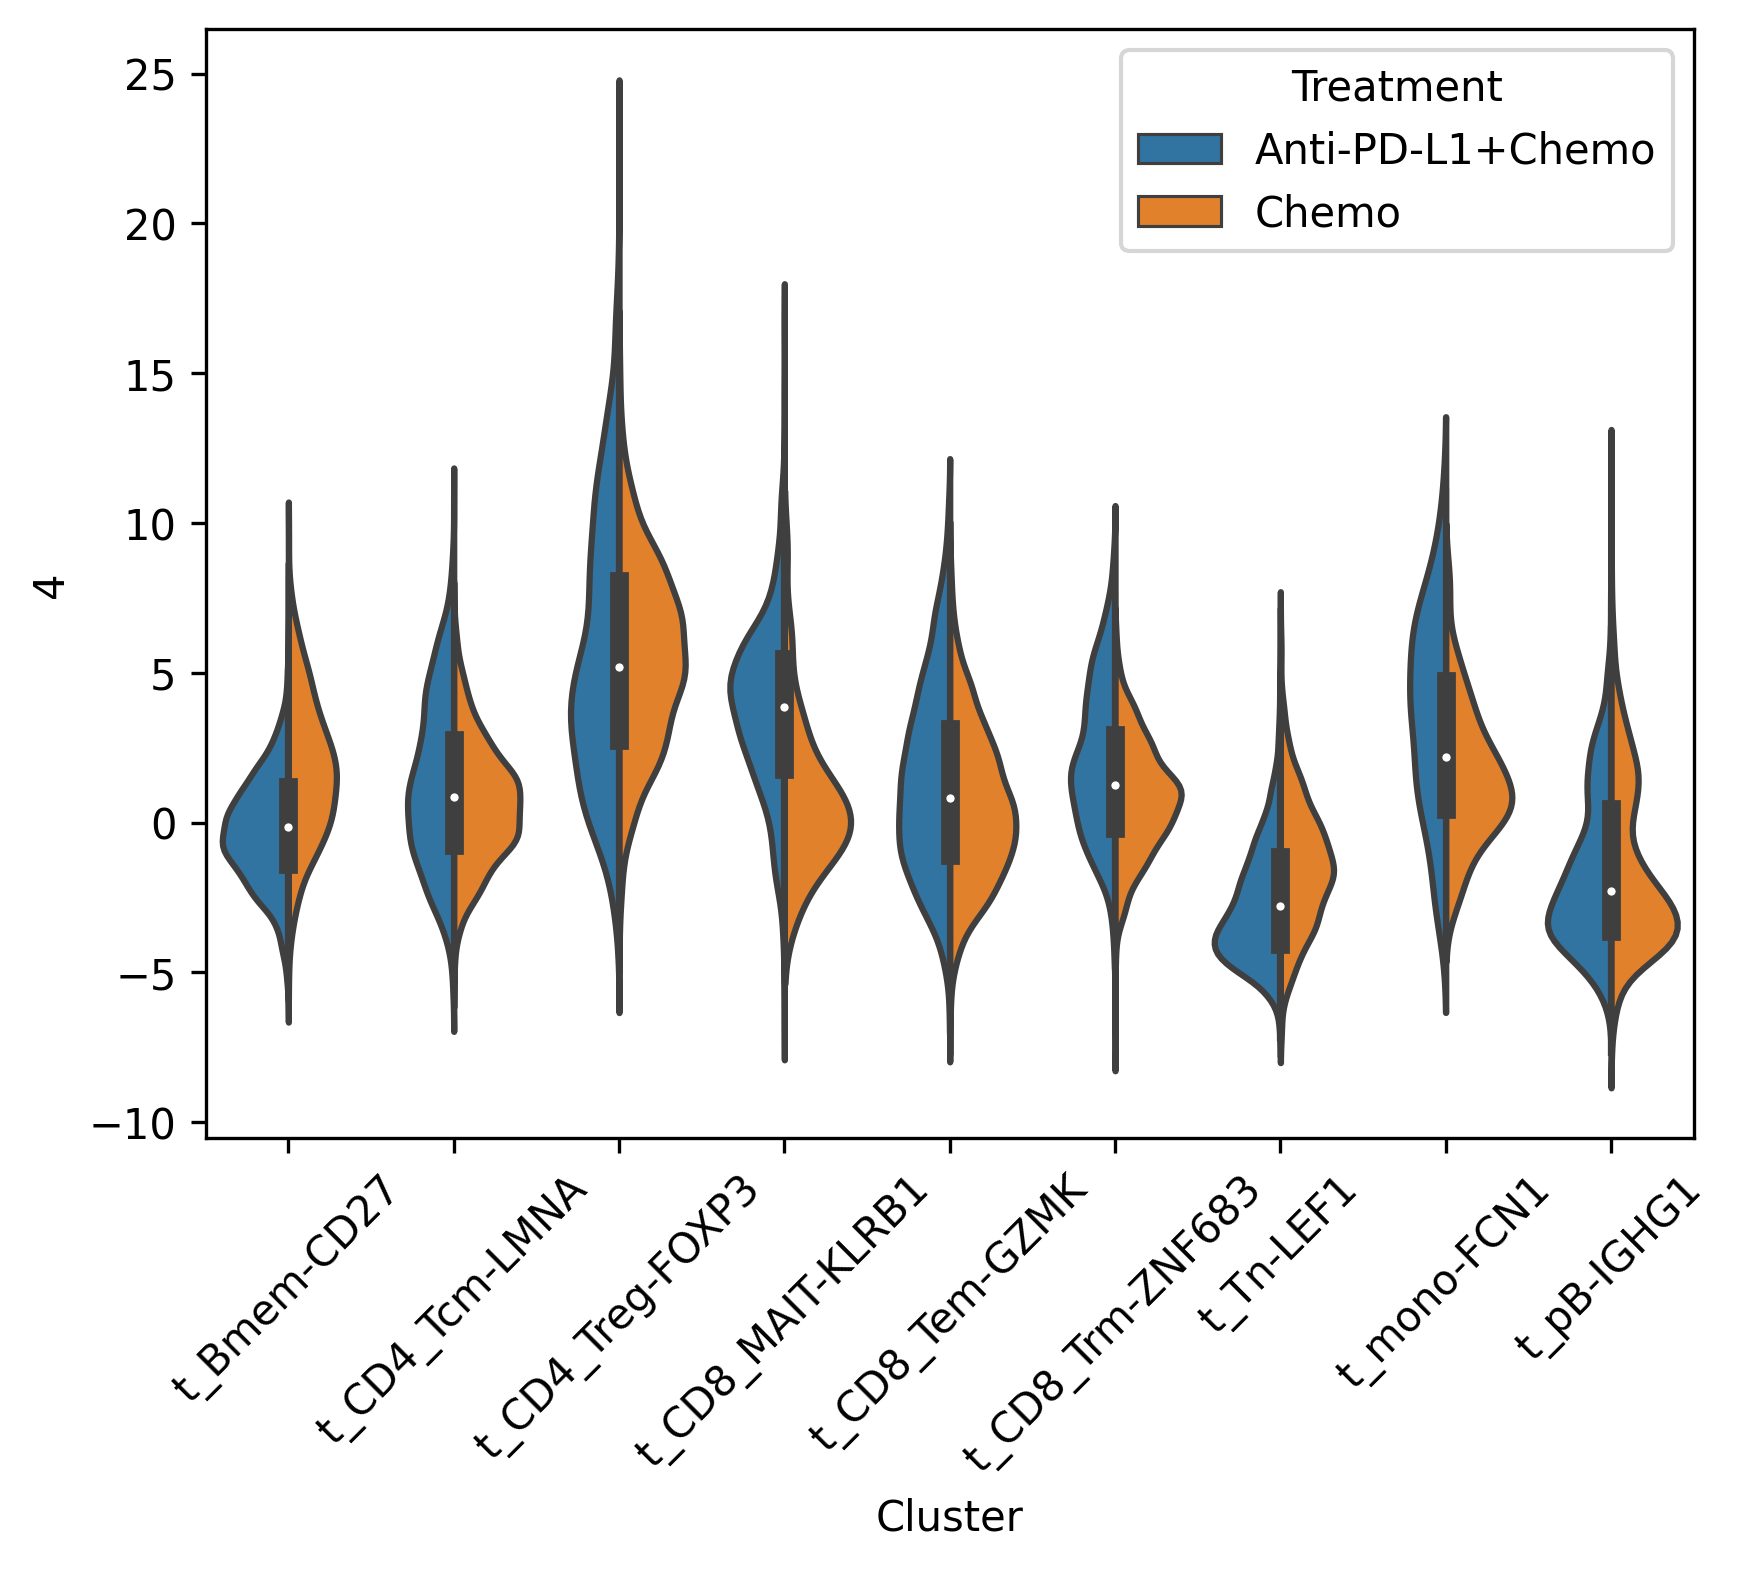

In [256]:
df = sc.get.obs_df(adata, ['Cluster','4', 'Treatment'])
#df = df.set_index('Efficacy').stack().reset_index()
#df.columns = []
#df.columns = ['Efficacy', 'MCP', 'value']
#import seaborn as sns
#sns.violinplot(data=df, x='gene', y='value', hue="louvain",
#                split=True, inner="quart", linewidth=1)    

p2 = sns.violinplot(data=df, x="Cluster",y="4",hue="Treatment", split=True)
p2.set_xticklabels(p2.get_xticklabels(), rotation=45)


# suggestion: separate out chemo response from other response 

In [254]:
adata

AnnData object with n_obs × n_vars = 42550 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'
    uns: 'Efficacy_colors', 'Cluster_colors'
    obsm: 'X_pca', 'X_umap'

In [258]:
adata.obs

Sample Patient Origin      Tissue Efficacy  \
Cell barcode                                                                  
AAATGCCTCATCTGCC.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
AATCCAGAGCGTTCCG.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
ACAGCCGAGCACCGCT.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
ACCGTAAAGCTAACTC.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
ACGAGCCTCGTAGGTT.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
...                                 ...     ...    ...         ...      ...   
CGGGTCAGTTCCCGAG.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   
GCTTGAACAGGCTGAA.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   
GTCGGGTGTCCGAATT.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   
TCATTTGTCAATACCG.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   
TCTCATATCCAAAGTC.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   

                                     Group         Treatment Number of counts  \
Cell barcode                                                                    
AAATGCCTCATCTGCC.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo           1,068    
AATCCAGAGCGTTCCG.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo           1,309    
ACAGCCGAGCACCGCT.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo           1,344    
ACCGTAAAGCTAACTC.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo             992    
ACGAGCCTCGTAGGTT.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo           1,482    
...                                    ...               ...              ...   
CGGGTCAGTTCCCGAG.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo           1,530    
GCTTGAACAGGCTGAA.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo          15,601    
GTCGGGTGTCCGAATT.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo          23,259    
TCATTTGTCAATACCG.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo          41,441    
TCTCATATCCAAAGTC.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo          13,445    

                            Number of genes Major celltype  ...         0  \
Cell barcode                                                ...             
AAATGCCTCATCTGCC.Pre_P007_t            513          B cell  ...  0.024630   
AATCCAGAGCGTTCCG.Pre_P007_t            545          B cell  ... -0.015568   
ACAGCCGAGCACCGCT.Pre_P007_t            499          B cell  ... -0.587769   
ACCGTAAAGCTAACTC.Pre_P007_t            560          B cell  ... -0.932235   
ACGAGCCTCGTAGGTT.Pre_P007_t            715          B cell  ...  1.184637   
...                                     ...            ...  ...       ...   
CGGGTCAGTTCCCGAG.Pre_P004_t            455          B cell  ...  0.587343   
GCTTGAACAGGCTGAA.Pre_P004_t          1,716          B cell  ...  0.142078   
GTCGGGTGTCCGAATT.Pre_P004_t          1,702          B cell  ... -0.874502   
TCATTTGTCAATACCG.Pre_P004_t          1,971          B cell  ... -0.753416   
TCTCATATCCAAAGTC.Pre_P004_t          1,418          B cell  ... -1.531930   

                                    1         2         3         4         5  \
Cell barcode                                                                    
AAATGCCTCATCTGCC.Pre_P007_t  1.731156 -0.744848 -1.153238 -2.364669 -0.565459   
AATCCAGAGCGTTCCG.Pre_P007_t  2.379186  0.599248 -0.514839 -0.284651 -2.689229   
ACAGCCGAGCACCGCT.Pre_P007_t  8.887239 -7.857848  1.351051 -0.978295  1.568127   
ACCGTAAAGCTAACTC.Pre_P007_t  1.265569  1.186969  4.360674  1.087998 -3.106793   
ACGAGCCTCGTAGGTT.Pre_P007_t  1.318599 -1.971468 -1.286478 -1.083146 -0.509761   
...                               ...       ...       ...       ...       ...   
CGGGTCAGTTCCCGAG.Pre_P004_t  8.492218 -4.851919  0.032954  8.585988 -4.671846   
GCTTGAACAGGCTGAA.Pre_P004_t  3.853591 -3.314564 -1.735825  1.445790  0.577677   
GTCGGGTGTCCGAATT.Pre_P004_t  9.149309 -4.820769  1.425461  5.622560  0.482708   
TCATTTGTCAATACCG.Pre_P004_t  6.059690 -3.811425 -1.175423 

In [262]:
adata.obs.groupby('Sample')['4'].mean()

Sample
Pre_P004_t    5.270521
Pre_P005_t    3.123903
Pre_P007_t   -3.217801
Pre_P012_t   -1.170567
Pre_P016_t    5.479860
Pre_P018_t    2.021408
Pre_P019_t   -0.606908
Pre_P020_t    0.896981
Pre_P022_t   -0.298503
Pre_P023_t    0.002636
Pre_P025_t    2.540024
Name: 4, dtype: float64

In [323]:
mean_mcps = adata.obs.groupby(['Sample','Cluster'])[[str(i) for i in range(0,10)]].mean()

In [324]:
mean_mcps['Efficacy']= adata.obs.groupby(['Sample','Cluster'])['Efficacy'].agg(pd.Series.mode)


In [325]:
mean_mcps['Treatment']=adata.obs.groupby(['Sample','Cluster'])['Treatment'].agg(pd.Series.mode)


mean_mcps

In [326]:
mean_mcps

0          1         2          3  \
Sample     Cluster                                                      
Pre_P004_t t_Bmem-CD27       0.681582   7.384475 -2.214836   0.381741   
           t_CD4_Tcm-LMNA   -0.419566   7.355825 -2.403693   0.061003   
           t_CD4_Treg-FOXP3 -0.143306   7.703682 -3.618304  -0.933352   
           t_CD8_MAIT-KLRB1 -0.773995   5.947383 -2.359044  -1.630408   
           t_CD8_Tem-GZMK   -1.082588   7.152841 -1.067013  -0.695885   
...                               ...        ...       ...        ...   
Pre_P025_t t_CD8_Tem-GZMK   -1.197396  11.522308  0.681213   3.078151   
           t_CD8_Trm-ZNF683 -1.146200  12.716036 -0.396044   4.882919   
           t_Tn-LEF1        -0.341718   8.006705  0.064817   3.336528   
           t_mono-FCN1      -3.028514  18.755076  0.481233  11.217707   
           t_pB-IGHG1       -0.212590   8.120909 -1.207545   2.988902   

                                    4         5         6          7  \
Sample     Cluster                                                     
Pre_P004_t t_Bmem-CD27       2.821699  0.587577  3.087229  -0.344274   
           t_CD4_Tcm-LMNA    4.074874  0.626491  2.901234   0.708336   
           t_CD4_Treg-FOXP3  9.092879  0.117198  2.825577  -1.402054   
           t_CD8_MAIT-KLRB1  3.987962 -1.268520  3.255535  -0.003192   
           t_CD8_Tem-GZMK    4.793798  0.119723  2.217708  -0.203729   
...                               ...       ...       ...        ...   
Pre_P025_t t_CD8_Tem-GZMK    2.625476  2.197002  2.771970   5.210516   
           t_CD8_Trm-ZNF683  1.950819  2.898844  1.707148   4.404909   
           t_Tn-LEF1         0.591289  2.048829  0.221910   6.991064   
           t_mono-FCN1       4.015364  7.417645  8.640546  10.025541   
           t_pB-IGHG1        1.559776 -0.409842 -0.901339   0.321430   

                                     8         9 Efficacy         Treatment  
Sample     Cluster                                                           
Pre_P004_t t_Bmem-CD27        2.380794  0.821484       SD  Anti-PD-L1+Chemo  
           t_CD4_Tcm-LMNA     2.927949  0.575786       SD  Anti-PD-L1+Chemo  
           t_CD4_Treg-FOXP3   8.571626  2.129996       SD  Anti-PD-L1+Chemo  
           t_CD8_MAIT-KLRB1   3.821417  2.039023       SD  Anti-PD-L1+Chemo  
           t_CD8_Tem-GZMK     4.259895  1.532937       SD  Anti-PD-L1+Chemo  
...                                ...       ...      ...               ...  
Pre_P025_t t_CD8_Tem-GZMK     1.708266  1.698675       SD             Chemo  
           t_CD8_Trm-ZNF683   2.212474  0.163236       SD             Chemo  
           t_Tn-LEF1         -0.833369  1.707644       SD             Chemo  
           t_mono-FCN1       11.375843 -5.444514       SD             Chemo  
           t_pB-IGHG1         7.178976 -1.557887       SD             Chemo  

[99 rows x 12 columns]

In [327]:
mean_mcps['0'].to_frame().reset_index()

Sample           Cluster         0
0   Pre_P004_t       t_Bmem-CD27  0.681582
1   Pre_P004_t    t_CD4_Tcm-LMNA -0.419566
2   Pre_P004_t  t_CD4_Treg-FOXP3 -0.143306
3   Pre_P004_t  t_CD8_MAIT-KLRB1 -0.773995
4   Pre_P004_t    t_CD8_Tem-GZMK -1.082588
..         ...               ...       ...
94  Pre_P025_t    t_CD8_Tem-GZMK -1.197396
95  Pre_P025_t  t_CD8_Trm-ZNF683 -1.146200
96  Pre_P025_t         t_Tn-LEF1 -0.341718
97  Pre_P025_t       t_mono-FCN1 -3.028514
98  Pre_P025_t        t_pB-IGHG1 -0.212590

[99 rows x 3 columns]

In [328]:
mean_mcps = mean_mcps.reset_index()

In [329]:
#mean_mcps = mean_mcps.set_index('Sample')

In [376]:
mean_mcps

Sample           Cluster         0          1         2          3  \
0   Pre_P004_t       t_Bmem-CD27  0.681582   7.384475 -2.214836   0.381741   
1   Pre_P004_t    t_CD4_Tcm-LMNA -0.419566   7.355825 -2.403693   0.061003   
2   Pre_P004_t  t_CD4_Treg-FOXP3 -0.143306   7.703682 -3.618304  -0.933352   
3   Pre_P004_t  t_CD8_MAIT-KLRB1 -0.773995   5.947383 -2.359044  -1.630408   
4   Pre_P004_t    t_CD8_Tem-GZMK -1.082588   7.152841 -1.067013  -0.695885   
..         ...               ...       ...        ...       ...        ...   
94  Pre_P025_t    t_CD8_Tem-GZMK -1.197396  11.522308  0.681213   3.078151   
95  Pre_P025_t  t_CD8_Trm-ZNF683 -1.146200  12.716036 -0.396044   4.882919   
96  Pre_P025_t         t_Tn-LEF1 -0.341718   8.006705  0.064817   3.336528   
97  Pre_P025_t       t_mono-FCN1 -3.028514  18.755076  0.481233  11.217707   
98  Pre_P025_t        t_pB-IGHG1 -0.212590   8.120909 -1.207545   2.988902   

           4         5         6          7          8         9 Efficacy  \
0   2.821699  0.587577  3.087229  -0.344274   2.380794  0.821484       SD   
1   4.074874  0.626491  2.901234   0.708336   2.927949  0.575786       SD   
2   9.092879  0.117198  2.825577  -1.402054   8.571626  2.129996       SD   
3   3.987962 -1.268520  3.255535  -0.003192   3.821417  2.039023       SD   
4   4.793798  0.119723  2.217708  -0.203729   4.259895  1.532937       SD   
..       ...       ...       ...        ...        ...       ...      ...   
94  2.625476  2.197002  2.771970   5.210516   1.708266  1.698675       SD   
95  1.950819  2.898844  1.707148   4.404909   2.212474  0.163236       SD   
96  0.591289  2.048829  0.221910   6.991064  -0.833369  1.707644       SD   
97  4.015364  7.417645  8.640546  10.025541  11.375843 -5.444514       SD   
98  1.559776 -0.409842 -0.901339   0.321430   7.178976 -1.557887       SD   

           Treatment  
0   Anti-PD-L1+Chemo  
1   Anti-PD-L1+Chemo  
2   Anti-PD-L1+Chemo  
3   Anti-PD-L1+Chemo  
4   Anti-PD-L1+Chemo  
..               ...  
94             Chemo  
95             Chemo  
96             Chemo  
97             Chemo  
98             Chemo  

[99 rows x 14 columns]

In [443]:
mcp4 = pd.pivot(mean_mcps[['Sample','Cluster','4']],index="Sample",columns = "Cluster" )['4']

In [444]:
#mcp4 = mean_mcps[['Sample','Cluster','4','Efficacy','Treatment']]

In [445]:
mcp4

Cluster     t_Bmem-CD27  t_CD4_Tcm-LMNA  t_CD4_Treg-FOXP3  t_CD8_MAIT-KLRB1  \
Sample                                                                        
Pre_P004_t     2.821699        4.074874          9.092879          3.987962   
Pre_P005_t     2.310590        1.985828          6.826035          4.240347   
Pre_P007_t    -0.805416       -0.977795          2.138185         -0.207305   
Pre_P012_t    -0.816237       -1.226769          2.253885         -1.033496   
Pre_P016_t     4.064823        3.621530         10.564403          5.545790   
Pre_P018_t     0.592880        0.958659          5.222837          0.537738   
Pre_P019_t    -0.079404       -0.186017          3.302542         -0.416721   
Pre_P020_t     0.321408       -0.265365          5.381289          0.610172   
Pre_P022_t     0.894882        0.679331          5.940815          0.207733   
Pre_P023_t     0.635419        0.369287          4.516698          0.332996   
Pre_P025_t     3.202446        2.254714          7.076762          3.941730   

Cluster     t_CD8_Tem-GZMK  t_CD8_Trm-ZNF683  t_Tn-LEF1  t_mono-FCN1  \
Sample                                                                 
Pre_P004_t        4.793798          4.762421   2.301447     6.654665   
Pre_P005_t        1.878354          2.019839  -1.149438     3.444968   
Pre_P007_t       -0.177446         -0.060127  -3.732638     1.170402   
Pre_P012_t       -1.773407         -0.351232  -2.952402    -1.841547   
Pre_P016_t        3.789841          4.437876   1.679402     4.005852   
Pre_P018_t        1.056456          0.601494   0.024006     0.564034   
Pre_P019_t        0.460394          0.607414  -2.119359     1.272080   
Pre_P020_t        0.204792         -0.230527  -1.597287     0.395616   
Pre_P022_t        0.398890          0.684115  -1.886743     2.186607   
Pre_P023_t       -0.121845          1.123827  -1.602291     0.562975   
Pre_P025_t        2.625476          1.950819   0.591289     4.015364   

Cluster     t_pB-IGHG1  
Sample                  
Pre_P004_t    1.751082  
Pre_P005_t    1.862427  
Pre_P007_t   -1.177890  
Pre_P012_t   -0.720151  
Pre_P016_t    1.317764  
Pre_P018_t   -0.533492  
Pre_P019_t   -2.041158  
Pre_P020_t   -1.783679  
Pre_P022_t   -2.264833  
Pre_P023_t   -1.585186  
Pre_P025_t    1.559776

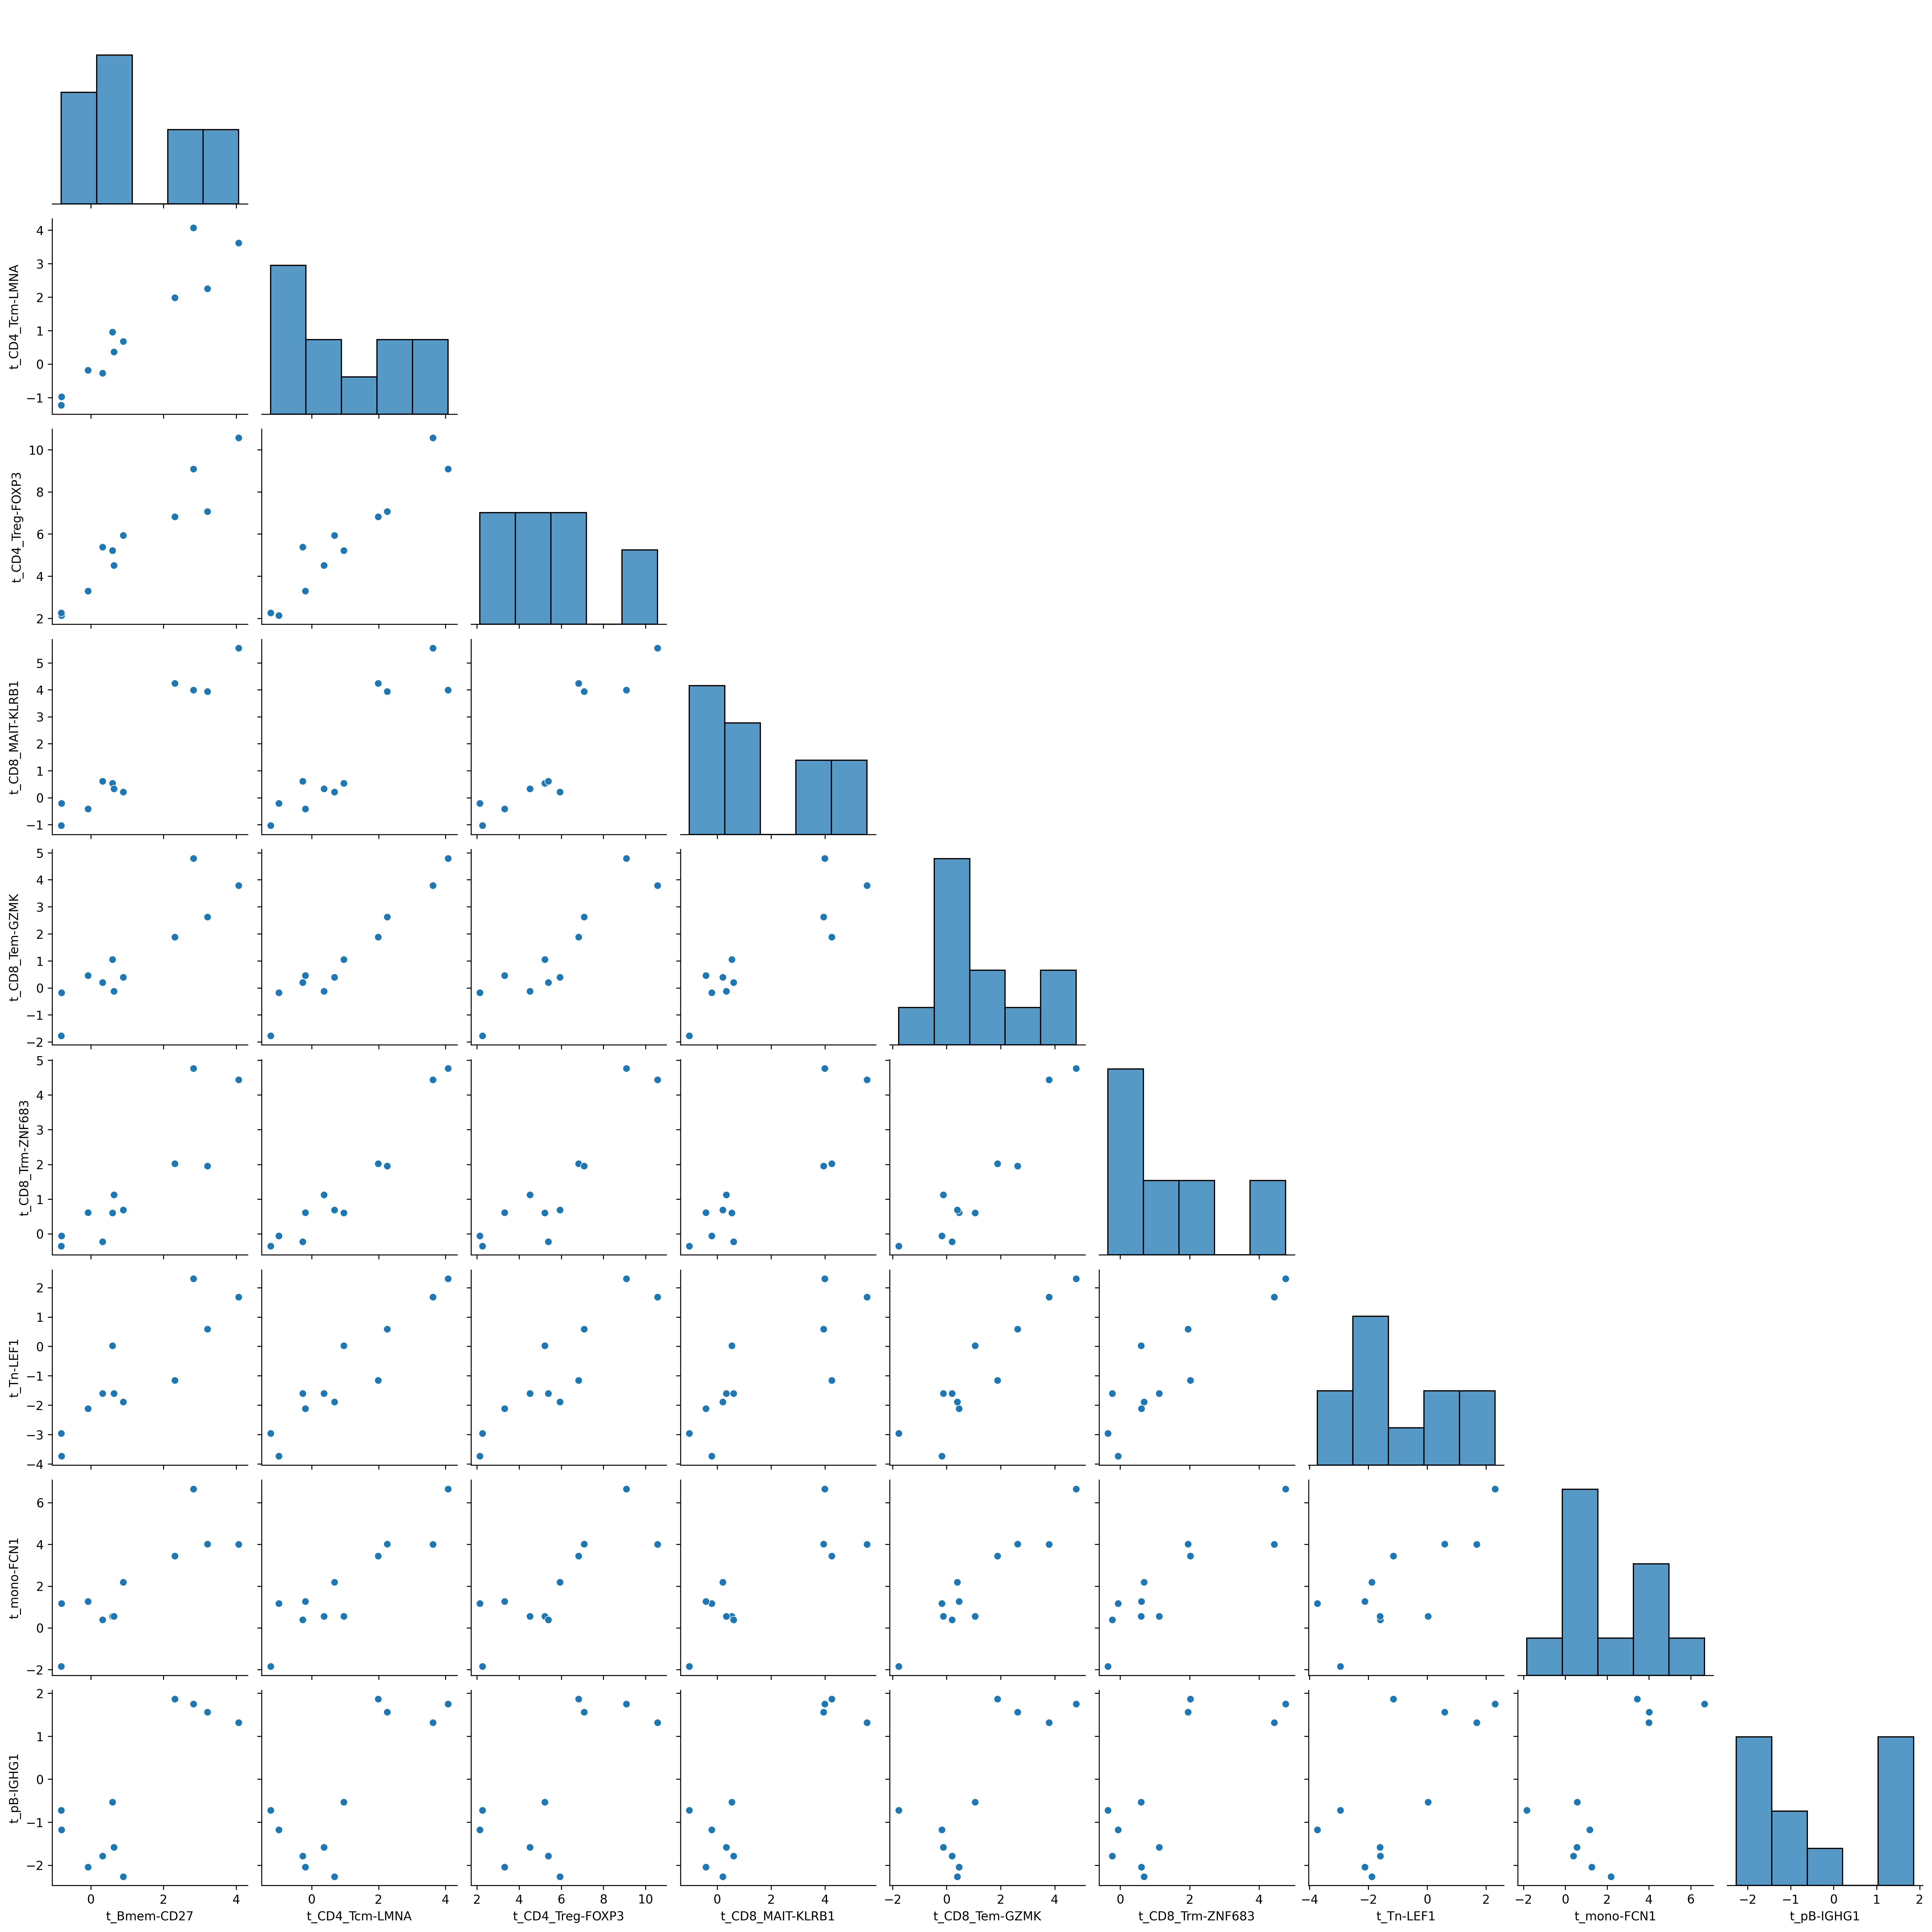

In [417]:
sns.pairplot(mcp4, corner=True)

In [456]:
mcp4 = pd.concat([mcp4,adata.obs.groupby(['Sample']).agg(pd.Series.mode)[['Efficacy','Treatment']]],axis=1)

In [457]:
mcp4

t_Bmem-CD27  t_CD4_Tcm-LMNA  t_CD4_Treg-FOXP3  t_CD8_MAIT-KLRB1  \
Sample                                                                        
Pre_P004_t     2.821699        4.074874          9.092879          3.987962   
Pre_P005_t     2.310590        1.985828          6.826035          4.240347   
Pre_P007_t    -0.805416       -0.977795          2.138185         -0.207305   
Pre_P012_t    -0.816237       -1.226769          2.253885         -1.033496   
Pre_P016_t     4.064823        3.621530         10.564403          5.545790   
Pre_P018_t     0.592880        0.958659          5.222837          0.537738   
Pre_P019_t    -0.079404       -0.186017          3.302542         -0.416721   
Pre_P020_t     0.321408       -0.265365          5.381289          0.610172   
Pre_P022_t     0.894882        0.679331          5.940815          0.207733   
Pre_P023_t     0.635419        0.369287          4.516698          0.332996   
Pre_P025_t     3.202446        2.254714          7.076762          3.941730   

            t_CD8_Tem-GZMK  t_CD8_Trm-ZNF683  t_Tn-LEF1  t_mono-FCN1  \
Sample                                                                 
Pre_P004_t        4.793798          4.762421   2.301447     6.654665   
Pre_P005_t        1.878354          2.019839  -1.149438     3.444968   
Pre_P007_t       -0.177446         -0.060127  -3.732638     1.170402   
Pre_P012_t       -1.773407         -0.351232  -2.952402    -1.841547   
Pre_P016_t        3.789841          4.437876   1.679402     4.005852   
Pre_P018_t        1.056456          0.601494   0.024006     0.564034   
Pre_P019_t        0.460394          0.607414  -2.119359     1.272080   
Pre_P020_t        0.204792         -0.230527  -1.597287     0.395616   
Pre_P022_t        0.398890          0.684115  -1.886743     2.186607   
Pre_P023_t       -0.121845          1.123827  -1.602291     0.562975   
Pre_P025_t        2.625476          1.950819   0.591289     4.015364   

            t_pB-IGHG1 Efficacy         Treatment  
Sample                                             
Pre_P004_t    1.751082       SD  Anti-PD-L1+Chemo  
Pre_P005_t    1.862427       SD  Anti-PD-L1+Chemo  
Pre_P007_t   -1.177890       PR  Anti-PD-L1+Chemo  
Pre_P012_t   -0.720151       PR  Anti-PD-L1+Chemo  
Pre_P016_t    1.317764       SD  Anti-PD-L1+Chemo  
Pre_P018_t   -0.533492       SD             Chemo  
Pre_P019_t   -2.041158       PR  Anti-PD-L1+Chemo  
Pre_P020_t   -1.783679       PR             Chemo  
Pre_P022_t   -2.264833       PR             Chemo  
Pre_P023_t   -1.585186       SD             Chemo  
Pre_P025_t    1.559776       SD             Chemo

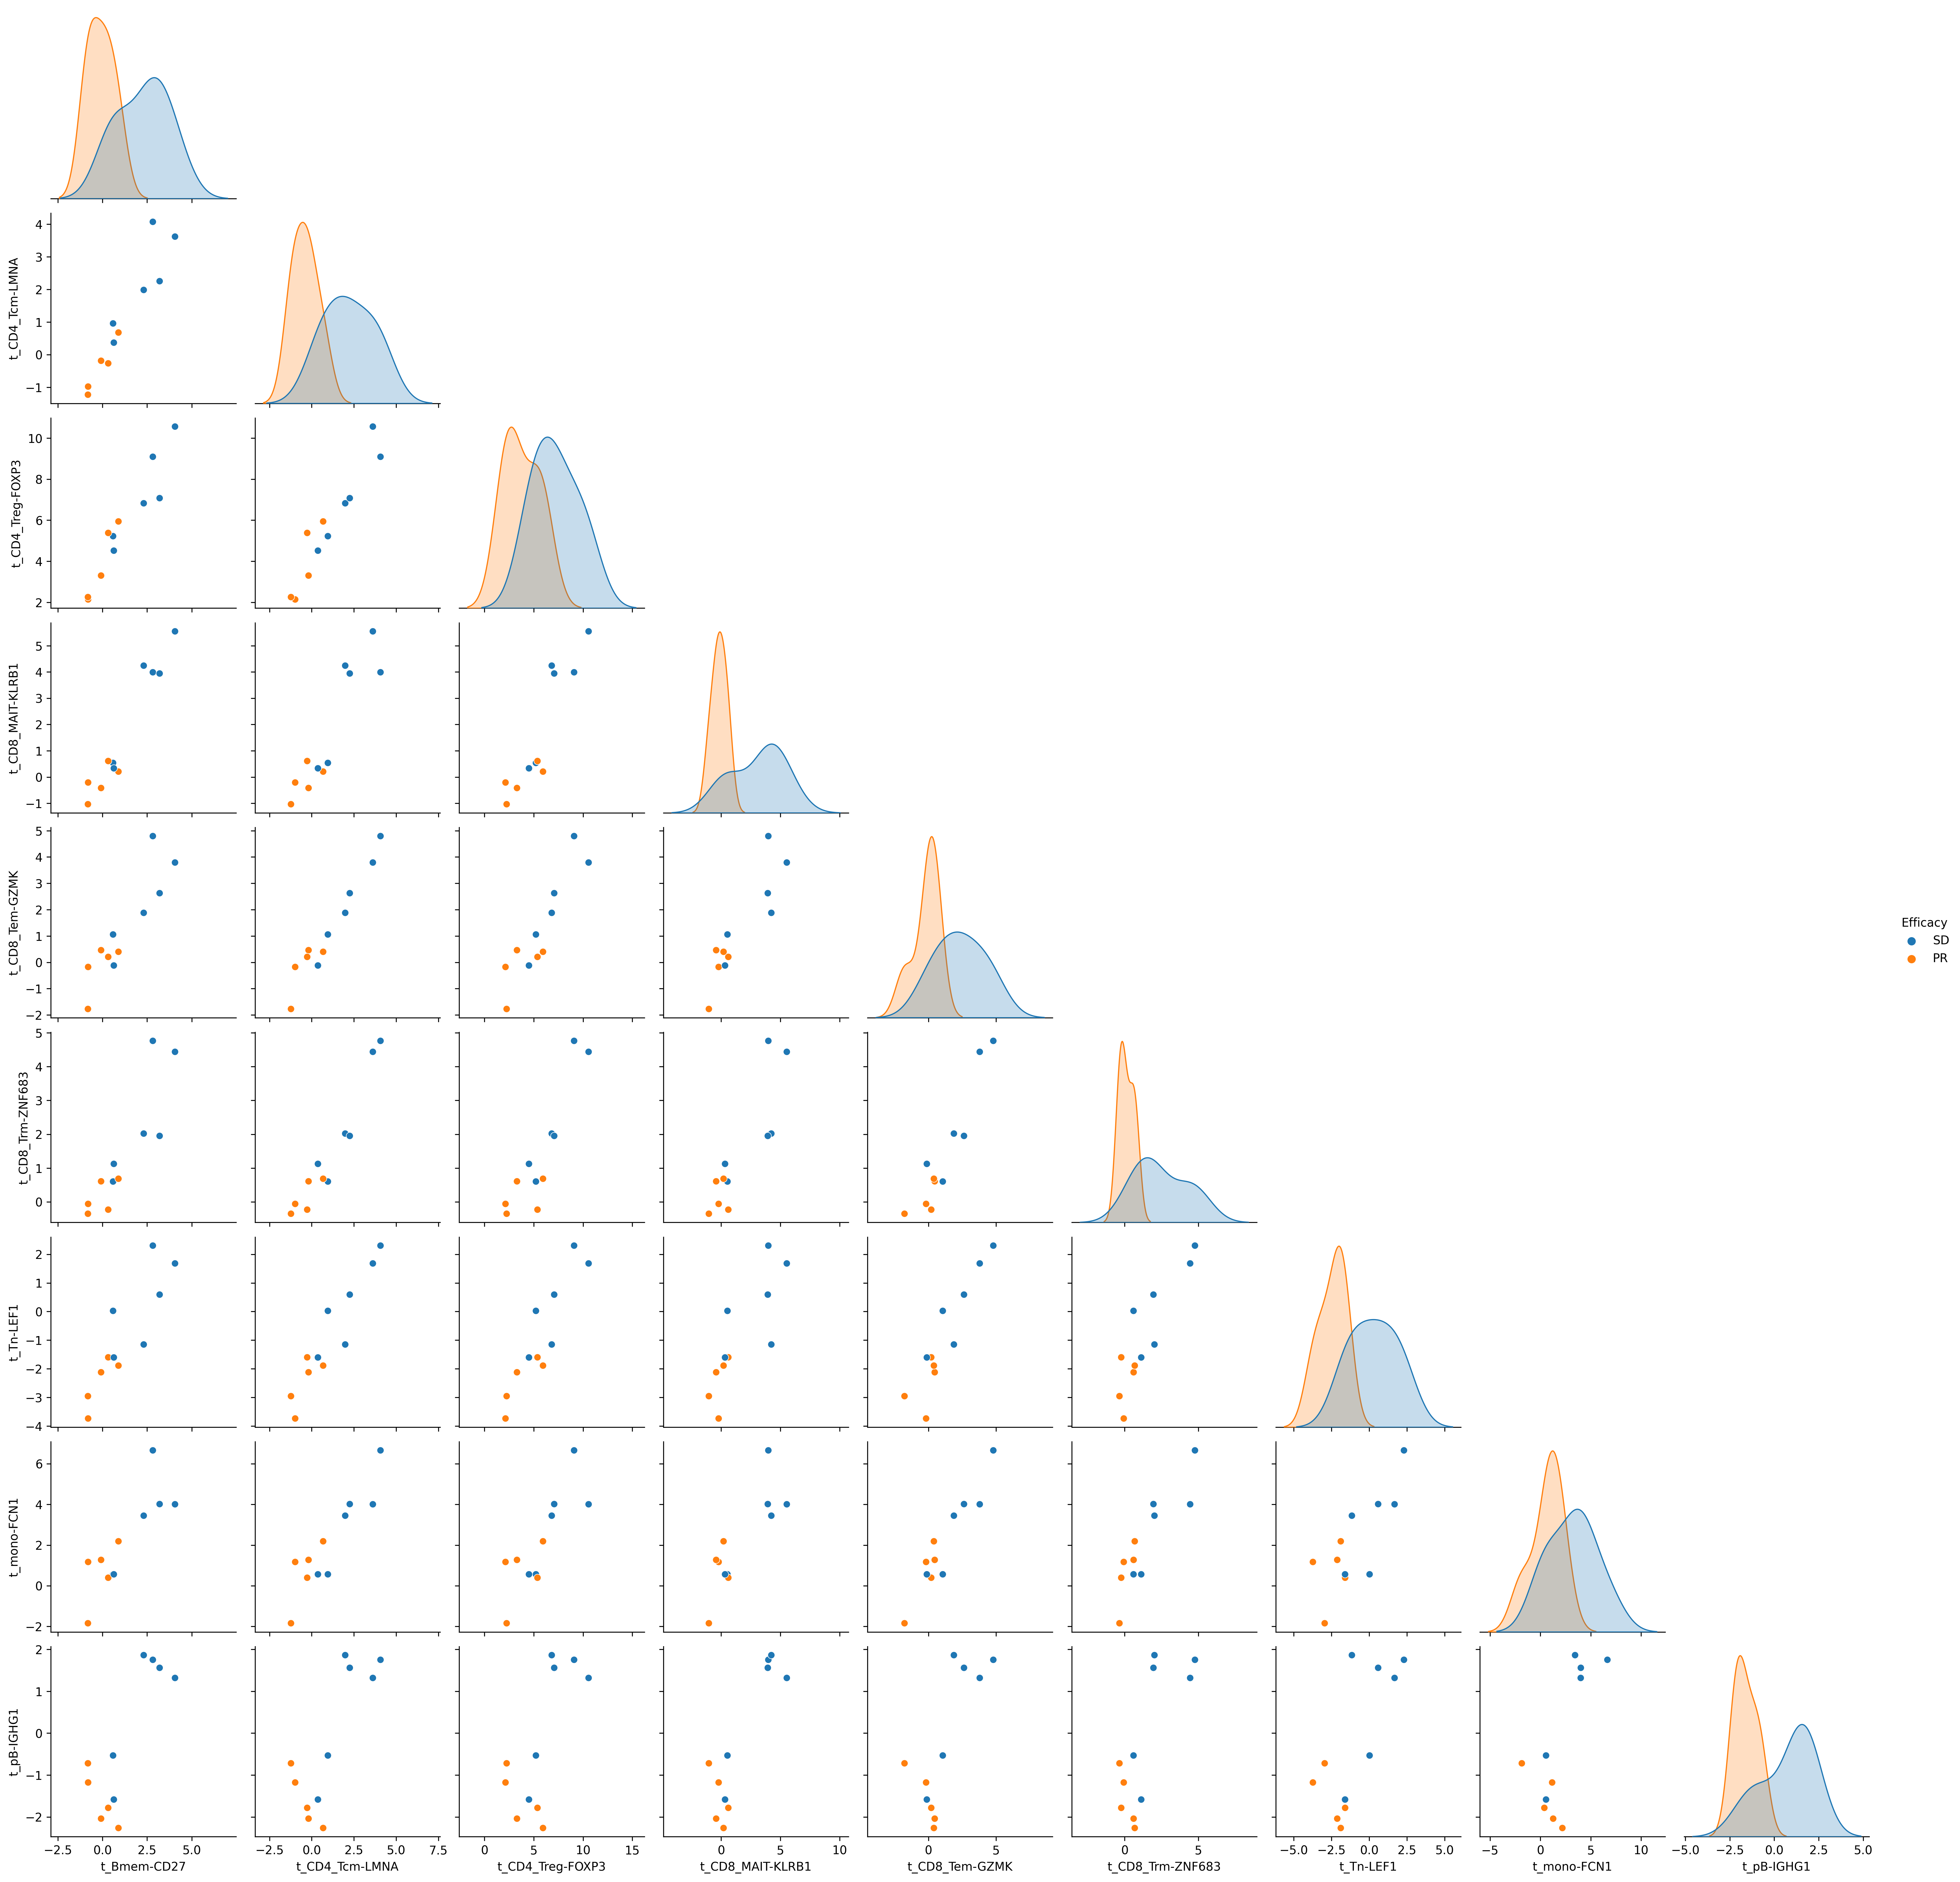

In [458]:
sns.pairplot(mcp4, corner=True, hue="Efficacy")

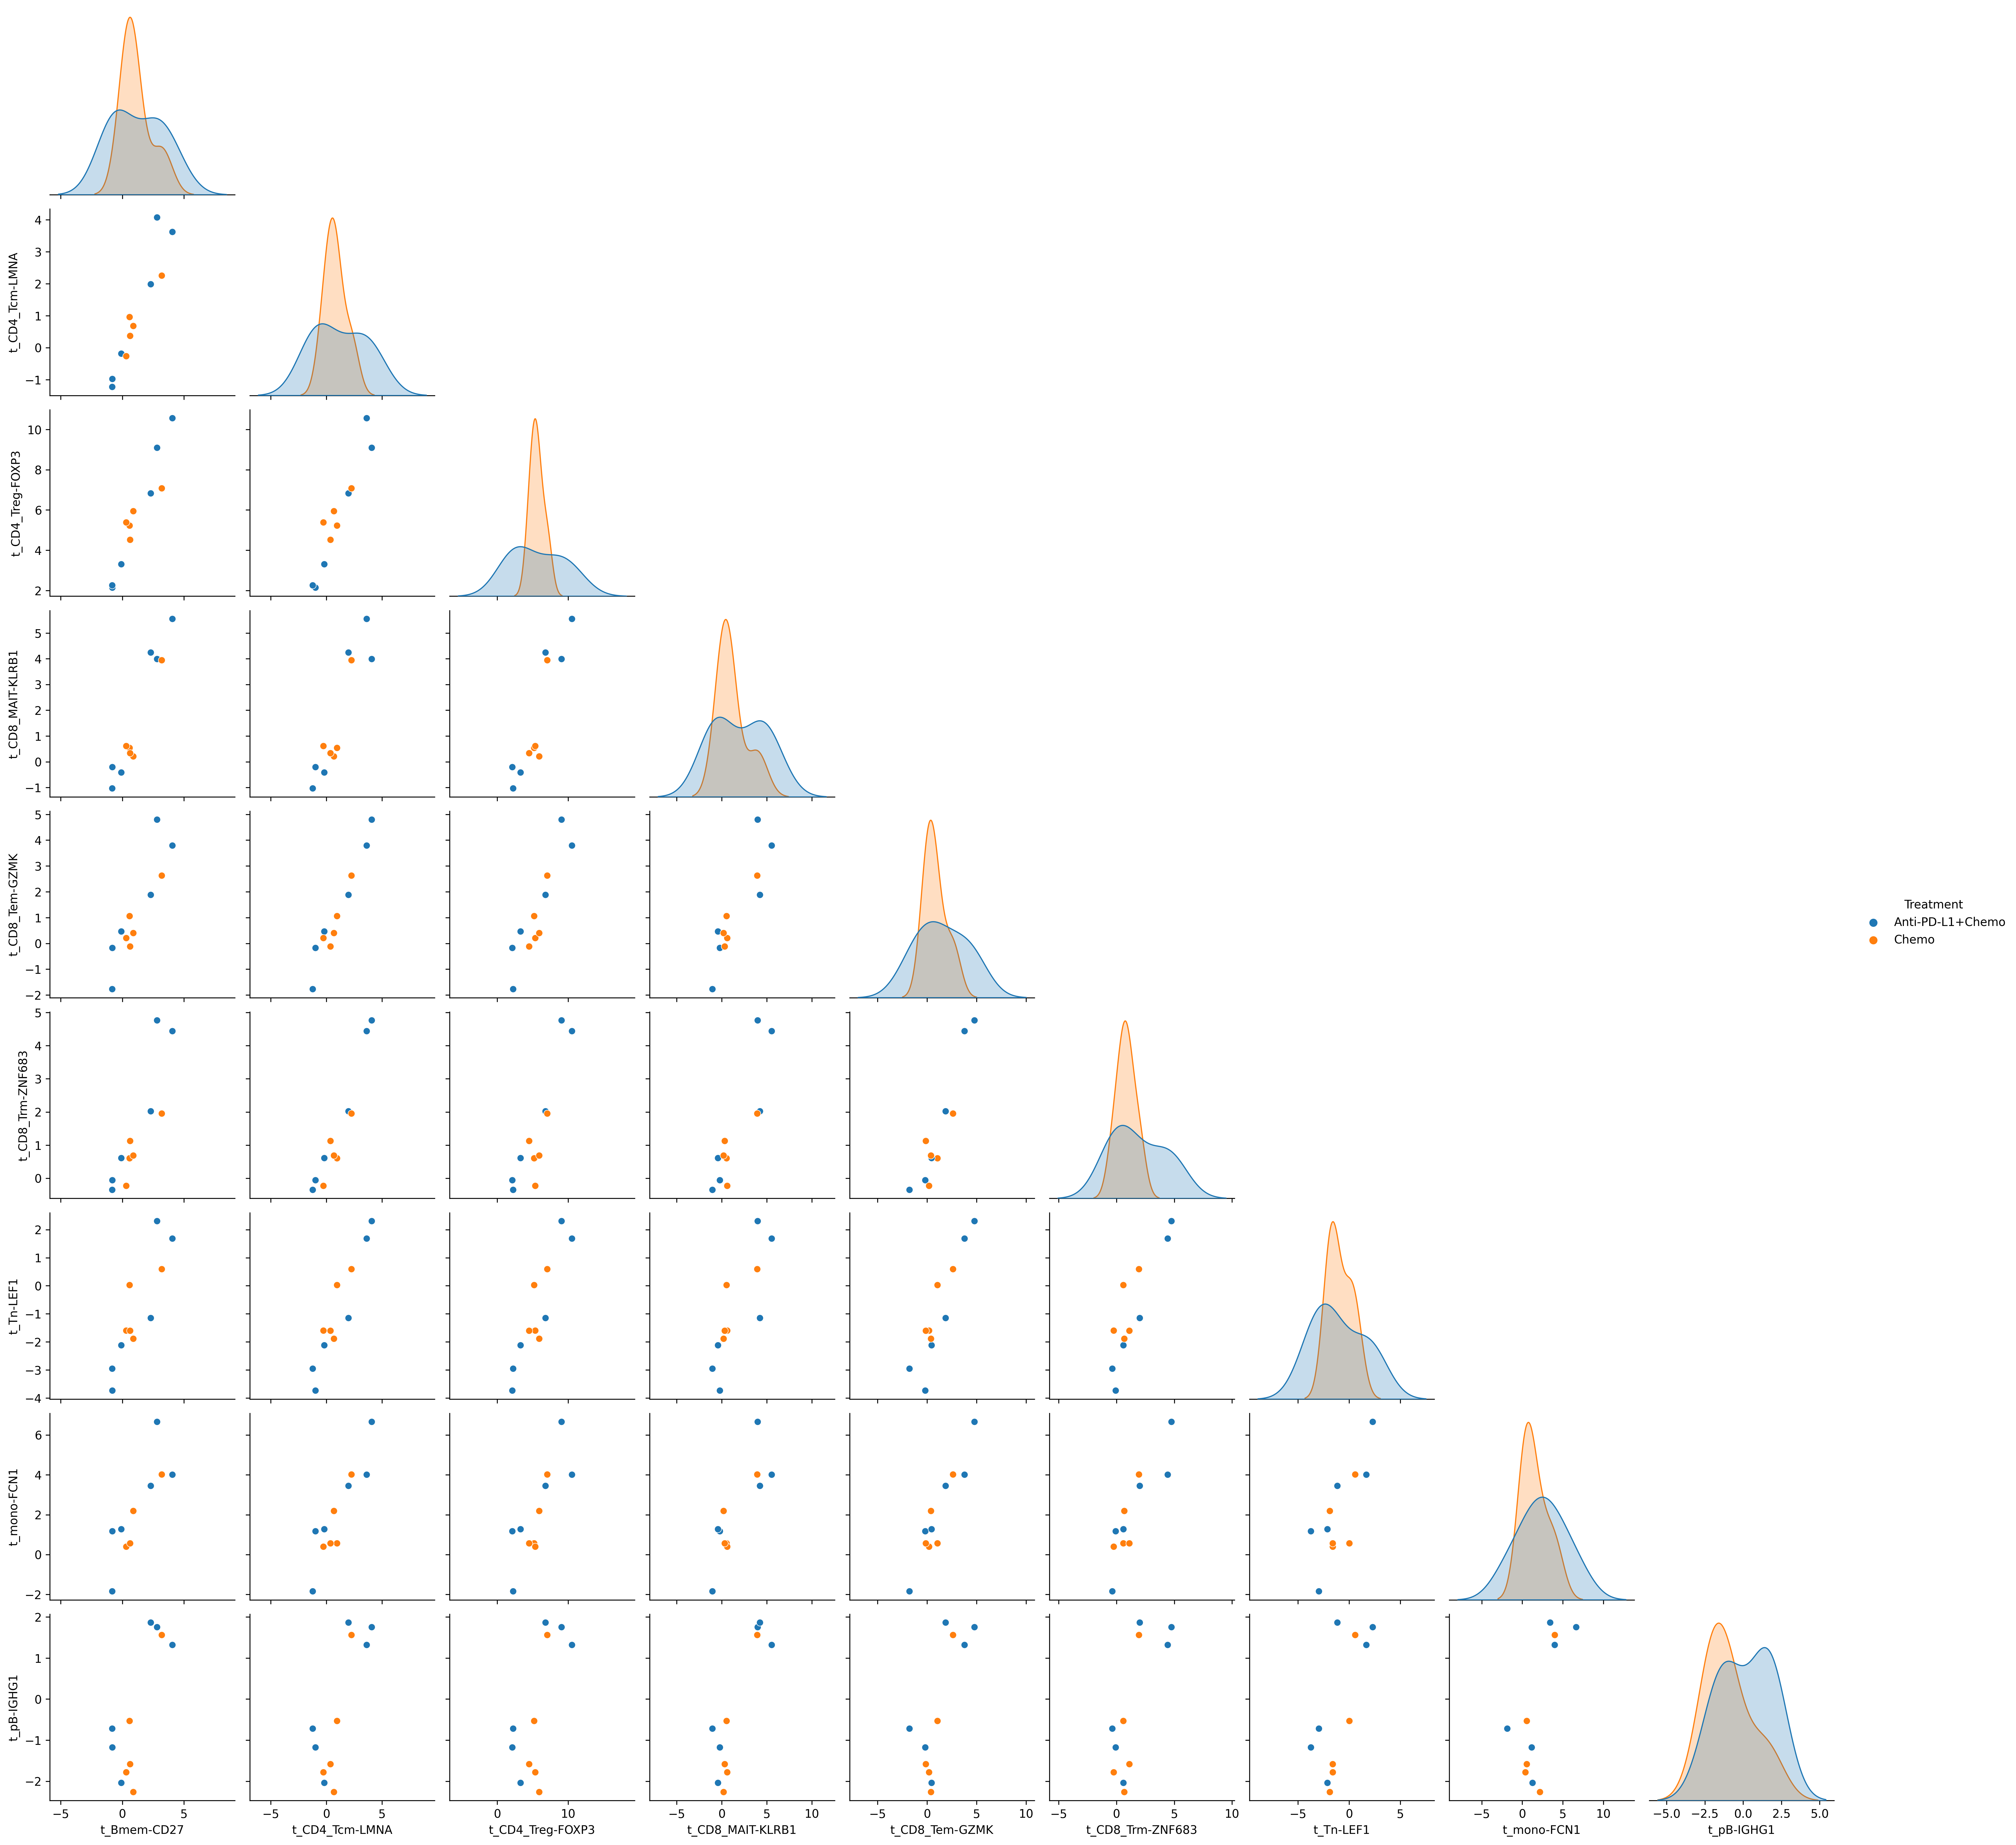

In [459]:
sns.pairplot(mcp4, corner=True, hue="Treatment")

Sample Patient Origin      Tissue Efficacy  \
Cell barcode                                                                  
AAATGCCTCATCTGCC.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
AATCCAGAGCGTTCCG.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
ACAGCCGAGCACCGCT.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
ACCGTAAAGCTAACTC.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
ACGAGCCTCGTAGGTT.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
...                                 ...     ...    ...         ...      ...   
CGGGTCAGTTCCCGAG.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   
GCTTGAACAGGCTGAA.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   
GTCGGGTGTCCGAATT.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   
TCATTTGTCAATACCG.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   
TCTCATATCCAAAGTC.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   

                                     Group         Treatment Number of counts  \
Cell barcode                                                                    
AAATGCCTCATCTGCC.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo           1,068    
AATCCAGAGCGTTCCG.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo           1,309    
ACAGCCGAGCACCGCT.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo           1,344    
ACCGTAAAGCTAACTC.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo             992    
ACGAGCCTCGTAGGTT.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo           1,482    
...                                    ...               ...              ...   
CGGGTCAGTTCCCGAG.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo           1,530    
GCTTGAACAGGCTGAA.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo          15,601    
GTCGGGTGTCCGAATT.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo          23,259    
TCATTTGTCAATACCG.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo          41,441    
TCTCATATCCAAAGTC.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo          13,445    

                            Number of genes Major celltype  ...         0  \
Cell barcode                                                ...             
AAATGCCTCATCTGCC.Pre_P007_t            513          B cell  ...  0.024630   
AATCCAGAGCGTTCCG.Pre_P007_t            545          B cell  ... -0.015568   
ACAGCCGAGCACCGCT.Pre_P007_t            499          B cell  ... -0.587769   
ACCGTAAAGCTAACTC.Pre_P007_t            560          B cell  ... -0.932235   
ACGAGCCTCGTAGGTT.Pre_P007_t            715          B cell  ...  1.184637   
...                                     ...            ...  ...       ...   
CGGGTCAGTTCCCGAG.Pre_P004_t            455          B cell  ...  0.587343   
GCTTGAACAGGCTGAA.Pre_P004_t          1,716          B cell  ...  0.142078   
GTCGGGTGTCCGAATT.Pre_P004_t          1,702          B cell  ... -0.874502   
TCATTTGTCAATACCG.Pre_P004_t          1,971          B cell  ... -0.753416   
TCTCATATCCAAAGTC.Pre_P004_t          1,418          B cell  ... -1.531930   

                                    1         2         3         4         5  \
Cell barcode                                                                    
AAATGCCTCATCTGCC.Pre_P007_t  1.731156 -0.744848 -1.153238 -2.364669 -0.565459   
AATCCAGAGCGTTCCG.Pre_P007_t  2.379186  0.599248 -0.514839 -0.284651 -2.689229   
ACAGCCGAGCACCGCT.Pre_P007_t  8.887239 -7.857848  1.351051 -0.978295  1.568127   
ACCGTAAAGCTAACTC.Pre_P007_t  1.265569  1.186969  4.360674  1.087998 -3.106793   
ACGAGCCTCGTAGGTT.Pre_P007_t  1.318599 -1.971468 -1.286478 -1.083146 -0.509761   
...                               ...       ...       ...       ...       ...   
CGGGTCAGTTCCCGAG.Pre_P004_t  8.492218 -4.851919  0.032954  8.585988 -4.671846   
GCTTGAACAGGCTGAA.Pre_P004_t  3.853591 -3.314564 -1.735825  1.445790  0.577677   
GTCGGGTGTCCGAATT.Pre_P004_t  9.149309 -4.820769  1.425461  5.622560  0.482708   
TCATTTGTCAATACCG.Pre_P004_t  6.059690 -3.811425 -1.175423 

In [535]:
full_adata = sc.read_h5ad("zhang_with_PCs.h5ad")

In [468]:
ws['t_Bmem-CD27'].shape

(50, 10)

In [471]:
ws['t_CD4_Treg-FOXP3'].shape

(50, 10)

In [481]:
full_adata[full_adata.obs['Cluster']=="t_Bmem-CD27",:].obsm['X_pca'].shape

(12639, 50)

In [486]:
Bmem_all = np.matmul(full_adata[full_adata.obs['Cluster']=="t_Bmem-CD27",:].obsm['X_pca'] ,ws['t_Bmem-CD27'])

In [564]:
def project_mcps(adata, ws, celltype_label = "Cluster",obsm_key = "X_pca", remove_celltypes = True):
    """
    Project the X_pca through ws for all cells
    If cells aren't in the celltype list returns 0
    
    
    """
    adata.obs[list(range(0,10))] =0
    if set(adata.obs[celltype_label].unique().to_list())!= set(ws.keys()):
        print("cell types do not match")
    if remove_celltypes:
        adata=adata[adata.obs['Cluster'].isin(ws.keys())]
    adata.obs
    for celltype in ws.keys():
        print(celltype)
        print(np.matmul(adata[adata.obs[celltype_label]==celltype,:].obsm[obsm_key] ,ws[celltype])
        # issue here is that you're trying to set values for the whole adata
        # but you want to set them for just the cells in this celltype
        adata.obs[list(range(0,10))]=np.matmul(adata[adata.obs[celltype_label]==celltype,:].obsm[obsm_key] ,ws[celltype])
    return(adata)
        

In [568]:
p.obs[list(range(0,10))]=0

In [577]:
adata.obs

Sample Patient Origin      Tissue Efficacy  \
Cell barcode                                                                  
AAATGCCTCATCTGCC.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
AATCCAGAGCGTTCCG.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
ACAGCCGAGCACCGCT.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
ACCGTAAAGCTAACTC.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
ACGAGCCTCGTAGGTT.Pre_P007_t  Pre_P007_t    P007      t  lymph_node       PR   
...                                 ...     ...    ...         ...      ...   
CGGGTCAGTTCCCGAG.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   
GCTTGAACAGGCTGAA.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   
GTCGGGTGTCCGAATT.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   
TCATTTGTCAATACCG.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   
TCTCATATCCAAAGTC.Pre_P004_t  Pre_P004_t    P004      t  chest_wall       SD   

                                     Group         Treatment Number of counts  \
Cell barcode                                                                    
AAATGCCTCATCTGCC.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo           1,068    
AATCCAGAGCGTTCCG.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo           1,309    
ACAGCCGAGCACCGCT.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo           1,344    
ACCGTAAAGCTAACTC.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo             992    
ACGAGCCTCGTAGGTT.Pre_P007_t  Pre-treatment  Anti-PD-L1+Chemo           1,482    
...                                    ...               ...              ...   
CGGGTCAGTTCCCGAG.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo           1,530    
GCTTGAACAGGCTGAA.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo          15,601    
GTCGGGTGTCCGAATT.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo          23,259    
TCATTTGTCAATACCG.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo          41,441    
TCTCATATCCAAAGTC.Pre_P004_t  Pre-treatment  Anti-PD-L1+Chemo          13,445    

                            Number of genes Major celltype  ...         0  \
Cell barcode                                                ...             
AAATGCCTCATCTGCC.Pre_P007_t            513          B cell  ...  0.024630   
AATCCAGAGCGTTCCG.Pre_P007_t            545          B cell  ... -0.015568   
ACAGCCGAGCACCGCT.Pre_P007_t            499          B cell  ... -0.587769   
ACCGTAAAGCTAACTC.Pre_P007_t            560          B cell  ... -0.932235   
ACGAGCCTCGTAGGTT.Pre_P007_t            715          B cell  ...  1.184637   
...                                     ...            ...  ...       ...   
CGGGTCAGTTCCCGAG.Pre_P004_t            455          B cell  ...  0.587343   
GCTTGAACAGGCTGAA.Pre_P004_t          1,716          B cell  ...  0.142078   
GTCGGGTGTCCGAATT.Pre_P004_t          1,702          B cell  ... -0.874502   
TCATTTGTCAATACCG.Pre_P004_t          1,971          B cell  ... -0.753416   
TCTCATATCCAAAGTC.Pre_P004_t          1,418          B cell  ... -1.531930   

                                    1         2         3         4         5  \
Cell barcode                                                                    
AAATGCCTCATCTGCC.Pre_P007_t  1.731156 -0.744848 -1.153238 -2.364669 -0.565459   
AATCCAGAGCGTTCCG.Pre_P007_t  2.379186  0.599248 -0.514839 -0.284651 -2.689229   
ACAGCCGAGCACCGCT.Pre_P007_t  8.887239 -7.857848  1.351051 -0.978295  1.568127   
ACCGTAAAGCTAACTC.Pre_P007_t  1.265569  1.186969  4.360674  1.087998 -3.106793   
ACGAGCCTCGTAGGTT.Pre_P007_t  1.318599 -1.971468 -1.286478 -1.083146 -0.509761   
...                               ...       ...       ...       ...       ...   
CGGGTCAGTTCCCGAG.Pre_P004_t  8.492218 -4.851919  0.032954  8.585988 -4.671846   
GCTTGAACAGGCTGAA.Pre_P004_t  3.853591 -3.314564 -1.735825  1.445790  0.577677   
GTCGGGTGTCCGAATT.Pre_P004_t  9.149309 -4.820769  1.425461  5.622560  0.482708   
TCATTTGTCAATACCG.Pre_P004_t  6.059690 -3.811425 -1.175423 

In [7]:
### DEBUG

In [9]:
ct_order = cell_types = adata.obs[dl.celltype_key].astype("category").cat.categories

In [10]:
ct_order

Index(['Mix', 'b_Bact-TNFRSF13B', 'b_Bmem-CD27', 'b_Bn-TCL1A',
       'b_CD4_Tcm-TCF7', 'b_CD4_Tem-GZMK', 'b_CD4_Tn-CCR7',
       'b_CD8_Teff-FGFBP2', 'b_CD8_Teff-GNLY', 'b_CD8_Tem-GZMK',
       'b_CD8_Tn-CCR7', 'b_CD14-EGR1', 'b_CD14-FCN1', 'b_CD14-FKBP5',
       'b_CD14-FOLR3', 'b_CD14-IFI6', 'b_CD14-IL1B', 'b_CD14-IPMK',
       'b_CD14-PF4', 'b_CD14-RETN', 'b_CD14-THBS1', 'b_CD16-CDKN1C',
       'b_ILC1-AKR1C3', 'b_ILC1-ATRX', 'b_ILC1-CD160', 'b_ILC1-CXCR4',
       'b_ILC1-HSPA8', 'b_ILC1-KLRC1', 'b_ILC1-KLRC2', 'b_ILC1-KLRC3',
       'b_ILC1-MKI67', 'b_ILC1-S100A9', 'b_ILC1-XCL1', 'b_Tgd-KLRB1',
       'b_Tprf-MKI67', 'b_baso-GATA2', 'b_cDC2-CLEC10A', 'b_mast-TPSAB1',
       'b_pB-IGHG1', 'b_pB-MKI67', 'b_pDC-LILRA4', 't_Bfoc-MKI67',
       't_Bfoc-NEIL1', 't_Bmem-CD27', 't_Bmem-MKI67', 't_Bn-TCL1A',
       't_CD4-CXCL13', 't_CD4_Tact-XIST', 't_CD4_Tcm-LMNA', 't_CD4_Treg-FOXP3',
       't_CD8-CXCL13', 't_CD8_MAIT-KLRB1', 't_CD8_Teff-GNLY', 't_CD8_Tem-GZMK',
       't_CD8_Trm-ZNF683

In [13]:
adata.obs.Cluster

Cell barcode
AAACCTGAGGTTACCT.Pre_P007_b       b_ILC1-HSPA8
AAACCTGCAAAGGAAG.Pre_P007_b     b_CD4_Tem-GZMK
AAACCTGCAAGTCTAC.Pre_P007_b     b_CD4_Tem-GZMK
AAACCTGCAATAAGCA.Pre_P007_b     b_CD4_Tcm-TCF7
AAACCTGCACAGCGTC.Pre_P007_b    b_CD8_Teff-GNLY
                                    ...       
TGGTTAGTCACTCTTA.Pre_P004_t       t_ILC2-SPON2
TGTTCCGTCTAACGGT.Pre_P004_t        t_ILC3-AREG
TTCGAAGCAATCCAAC.Pre_P004_t        t_ILC3-AREG
TTCTCAATCATCATTC.Pre_P004_t        t_ILC3-AREG
TTCTTAGAGAAGCCCA.Pre_P004_t        t_ILC1-IL32
Name: Cluster, Length: 489490, dtype: category
Categories (97, object): ['Mix', 'b_Bact-TNFRSF13B', 'b_Bmem-CD27', 'b_Bn-TCL1A', ..., 't_mono-S100A89', 't_mono-SMIM25', 't_pB-IGHG1', 't_pDC-LILRA4']

In [17]:
adata.obs['Cluster'].cat.remove_unused_categories()


Cell barcode
AAACCTGAGGTTACCT.Pre_P007_b       b_ILC1-HSPA8
AAACCTGCAAAGGAAG.Pre_P007_b     b_CD4_Tem-GZMK
AAACCTGCAAGTCTAC.Pre_P007_b     b_CD4_Tem-GZMK
AAACCTGCAATAAGCA.Pre_P007_b     b_CD4_Tcm-TCF7
AAACCTGCACAGCGTC.Pre_P007_b    b_CD8_Teff-GNLY
                                    ...       
TGGTTAGTCACTCTTA.Pre_P004_t       t_ILC2-SPON2
TGTTCCGTCTAACGGT.Pre_P004_t        t_ILC3-AREG
TTCGAAGCAATCCAAC.Pre_P004_t        t_ILC3-AREG
TTCTCAATCATCATTC.Pre_P004_t        t_ILC3-AREG
TTCTTAGAGAAGCCCA.Pre_P004_t        t_ILC1-IL32
Name: Cluster, Length: 489490, dtype: category
Categories (97, object): ['Mix', 'b_Bact-TNFRSF13B', 'b_Bmem-CD27', 'b_Bn-TCL1A', ..., 't_mono-S100A89', 't_mono-SMIM25', 't_pB-IGHG1', 't_pDC-LILRA4']

In [18]:
adata.obs['Cluster'].unique()

['b_ILC1-HSPA8', 'b_CD4_Tem-GZMK', 'b_CD4_Tcm-TCF7', 'b_CD8_Teff-GNLY', 'b_CD8_Tem-GZMK', ..., 'Mix', 't_macro-CD24', 't_cDC2-CD207', 'b_CD14-IL1B', 't_cDC2-FCGR2B']
Length: 97
Categories (97, object): ['Mix', 'b_Bact-TNFRSF13B', 'b_Bmem-CD27', 'b_Bn-TCL1A', ..., 't_mono-S100A89', 't_mono-SMIM25', 't_pB-IGHG1', 't_pDC-LILRA4']

In [ ]:
    def calculate_multifactor_PMD(  # noqa: N802
        self,
        adata: AnnData,
        penalties: list[int] = None,
        ct_order: list[str] = None,
        agg_pca: bool = True,
        solver: Literal["lp", "bs"] = "bs",
        normalize: bool = True,
    ) -> tuple[AnnData, dict[str, np.ndarray], dict[Any, Any], dict[Any, Any]]:
        """Runs multifactor PMD.
        Currently mimics DIALOGUE1.
        Args:
            adata: AnnData object to calculate PMD for.
            sample_id: Key to use for pseudobulk determination.
            penalties: PMD penalties.
            ct_order: The order of cell types.
            agg_pca: Whether to calculate cell-averaged PCA components.
            solver: Which solver to use for PMD. Must be one of "lp" (linear programming) or "bs" (binary search).
                    For differences between these to please refer to https://github.com/theislab/sparsecca/blob/main/examples/linear_programming_multicca.ipynb
                    Defaults to 'bs'.
            normalize: Whether to mimic DIALOGUE as close as possible
        Returns:
            MCP scores  # TODO this requires more detail
        """
        # IMPORTANT NOTE: the order in which matrices are passed to multicca matters. As such,
        # it is important here that to obtain the same result as in R, we pass the matrices in
        # in the same order.
        if ct_order is not None:
            cell_types = ct_order
        else:
            ct_order = cell_types = adata.obs[self.celltype_key].astype("category").cat.categories

        mcca_in, ct_subs = self.load(adata, ct_order=cell_types, agg_pca=agg_pca, normalize=normalize)

        n_samples = mcca_in[0].shape[1]
        if penalties is None:
            penalties = multicca_permute(
                mcca_in, penalties=np.sqrt(n_samples) / 2, nperms=10, niter=50, standardize=True
            )["bestpenalties"]
        else:
            penalties = penalties

        if solver == "bs":
            ws, _ = multicca_pmd(mcca_in, penalties, K=self.n_mcps, standardize=True, niter=100, mimic_R=normalize)
        elif solver == "lp":
            ws, _ = lp_pmd(mcca_in, penalties, K=self.n_mcps, standardize=True, mimic_R=normalize)
        else:
            raise ValueError('Please select a valid solver. Must be one of "lp" or "bs".')
        ws_dict = {ct: ws[i] for i, ct in enumerate(ct_order)}

        pre_r_scores = {
            ct: ct_subs[ct].obsm["X_pca"][:, :50] @ ws[i] for i, ct in enumerate(cell_types)  # TODO change from 50
        }

        # TODO: output format needs some cleanup, even though each MCP score is matched to one cell, it's not at all
        # matched at this point in the function and requires references to internals that shouldn't need exposing (ct_subs)

        mcp_scores = {
            ct: self._get_residuals(ct_subs[ct].obs[self.n_counts_key].values, pre_r_scores[ct].T).T
            for i, ct in enumerate(cell_types)
        }

        adata = self._concat_adata_mcp_scores(
            adata, ct_subs=ct_subs, mcp_scores=mcp_scores, celltype_key=self.celltype_key
        )

        return adata, mcp_scores, ws_dict, ct_subs

In [55]:
ct_order = cell_types = adata.obs[dl.celltype_key].astype("category").cat.categories


In [56]:
ct_order

Index(['t_Bmem-CD27', 't_CD4_Tcm-LMNA', 't_CD4_Treg-FOXP3', 't_CD8_MAIT-KLRB1',
       't_CD8_Tem-GZMK', 't_CD8_Trm-ZNF683', 't_Tn-LEF1', 't_mono-FCN1',
       't_pB-IGHG1'],
      dtype='object')

In [57]:
mcca_in, ct_subs = dl.load(adata, ct_order=cell_types, agg_pca=True, normalize=False)

In [68]:
dl.sample_id

'Sample'

In [61]:
n_samples = mcca_in[0].shape[1]

In [71]:
n_samples

50

In [70]:
adata.obs['Sample'].unique()

['Pre_P007_t', 'Pre_P012_t', 'Pre_P023_t', 'Pre_P018_t', 'Pre_P016_t', ..., 'Pre_P022_t', 'Pre_P019_t', 'Pre_P020_t', 'Pre_P005_t', 'Pre_P004_t']
Length: 11
Categories (11, object): ['Pre_P004_t', 'Pre_P005_t', 'Pre_P007_t', 'Pre_P012_t', ..., 'Pre_P020_t', 'Pre_P022_t', 'Pre_P023_t', 'Pre_P025_t']

In [74]:
adata.obs['Cluster'].unique()

['t_Tn-LEF1', 't_CD8_Tem-GZMK', 't_CD8_MAIT-KLRB1', 't_Bmem-CD27', 't_CD4_Treg-FOXP3', 't_CD8_Trm-ZNF683', 't_CD4_Tcm-LMNA', 't_pB-IGHG1', 't_mono-FCN1']
Categories (9, object): ['t_Bmem-CD27', 't_CD4_Tcm-LMNA', 't_CD4_Treg-FOXP3', 't_CD8_MAIT-KLRB1', ..., 't_CD8_Trm-ZNF683', 't_Tn-LEF1', 't_mono-FCN1', 't_pB-IGHG1']